In [ ]:
import pysam

In [ ]:
#path
f1 = pysam.AlignmentFile('../resources/CRISPRCapV3_S45_R2_001Aligned.sortedByCoord.out.bam','rb')
f2 = pysam.AlignmentFile('../resources/CRISPRCapV4_S51_R2_001/CRISPRCapV4_S51_R2_001Aligned.sortedByCoord.out.bam','rb')

In [ ]:
from selene_sdk.targets import Target
import tabix
import pyBigWig
class GenomicSignalFeatures(Target):
    """
    #Accept a list of cooler files as input.
    """
    def __init__(self, input_paths, features, shape, blacklists=None, blacklists_indices=None, 
        replacement_indices=None, replacement_scaling_factors=None):
        """
        Constructs a new `GenomicFeatures` object.
        """
        self.input_paths = input_paths
        self.initialized = False
        self.blacklists = blacklists
        self.blacklists_indices = blacklists_indices
        self.replacement_indices = replacement_indices
        self.replacement_scaling_factors = replacement_scaling_factors

            
        self.n_features = len(features)
        self.feature_index_dict = dict(
            [(feat, index) for index, feat in enumerate(features)])
        self.shape = (len(input_paths), *shape)

    def get_feature_data(self, chrom, start, end, nan_as_zero=True):
        if not self.initialized:
            self.data = [pyBigWig.open(path) for path in self.input_paths]
            if self.blacklists is not None:
                self.blacklists = [tabix.open(blacklist)  for blacklist in self.blacklists]
            self.initialized=True
            
        wigmat = np.vstack([c.values(chrom, start, end, numpy=True)
                           for c in self.data])
        
        if self.blacklists is not None:
            if self.replacement_indices is None:
                for blacklist, blacklist_indices in zip(self.blacklists, self.blacklists_indices):
                    for _, s, e in blacklist.query(chrom, start, end):
                        wigmat[blacklist_indices, np.fmax(int(s)-start,0): int(e)-start] = 0
            else:
                for blacklist, blacklist_indices, replacement_indices, replacement_scaling_factor in zip(self.blacklists, self.blacklists_indices, self.replacement_indices, self.replacement_scaling_factors):
                        for _, s, e in blacklist.query(chrom, start, end):
                            wigmat[blacklist_indices, np.fmax(int(s)-start,0): int(e)-start] = wigmat[replacement_indices, np.fmax(int(s)-start,0): int(e)-start] * replacement_scaling_factor

        if nan_as_zero:
            wigmat[np.isnan(wigmat)]=0
        return wigmat



tfeature = GenomicSignalFeatures(["../resources/agg.plus.bw.bedgraph.bw",
"../resources/agg.encodecage.plus.v2.bedgraph.bw",
"../resources/agg.encoderampage.plus.v2.bedgraph.bw",
"../resources/agg.plus.grocap.bedgraph.sorted.merged.bw",
"../resources/agg.plus.allprocap.bedgraph.sorted.merged.bw",
"../resources/agg.minus.allprocap.bedgraph.sorted.merged.bw",
"../resources/agg.minus.grocap.bedgraph.sorted.merged.bw",
"../resources/agg.encoderampage.minus.v2.bedgraph.bw",
"../resources/agg.encodecage.minus.v2.bedgraph.bw",
"../resources/agg.minus.bw.bedgraph.bw"],
                               ['cage_plus','encodecage_plus','encoderampage_plus', 'grocap_plus','procap_plus','procap_minus','grocap_minus'
,'encoderampage_minus', 'encodecage_minus',
'cage_minus'],
                               (100000,),
                               ["../resources/fantom.blacklist8.plus.bed.gz","../resources/fantom.blacklist8.minus.bed.gz"],
                               [0,9], [1,8], [0.61357, 0.61357])



In [ ]:
from collections import defaultdict
import pysam

def read_pair_generator(bam, region_string=None):
    """
    Generate read pairs in a BAM file or within a region string.
    Reads are added to read_dict until a pair is found.
    """
    read_dict = defaultdict(lambda: [None, None])
    for read in bam.fetch(region=region_string):
        if not read.is_proper_pair or read.is_secondary or read.is_supplementary:
            continue
        qname = read.query_name
        if qname not in read_dict:
            if read.is_read1:
                read_dict[qname][0] = read
            else:
                read_dict[qname][1] = read
        else:
            if read.is_read1:
                yield read, read_dict[qname][1]
            else:
                yield read_dict[qname][0], read
            del read_dict[qname]

            

In [ ]:
def is_covered(read, pos, low_thresh=2, high_thresh=100):
    relpos = np.array(read.get_reference_positions()) - pos
    if np.any((relpos < -low_thresh) * (relpos > -high_thresh)) and np.any( (relpos > low_thresh) * (relpos < high_thresh)):
        return True
    else:
        return False


In [ ]:
metadata =[['HIST1H1D', 'chr6', 26234986, '-', 93, 92],
['C1orf63', 'chr1', 25247453, '-', 15, 14],
['EDEM2', 'chr20', 35278121, '-', 14, 14],
['RBM4', 'chr11', 66616629, '+', 14, 14],
['IRF1', 'chr5', 132490772, '-', 14, 14],
['TMED9', 'chr5', 177592202, '+', 16, 14],
['NDUFV3', 'chr21', 42893312, '+',22, 23],
['HSF1', 'chr8', 144291604, '+', 9,  10],
#['SMCHD1', 'chr18', 2655725, '+', 134, 133],
['TXNRD2', 'chr22', 19941817, '-', 57, 59],
#['SYNGR3', 'chr16', 1992523, '+', 155, 156],
['SOCS1', 'chr16', 11256199,'-', 46, 49],
['C19orf43', 'chr19', 12734681, '-', 44, 46],
#['ICAM1', 'chr19', 10271119, '+', 52, 60],
['ECI1', 'chr16', 2251586, '-', 9, 23],
['LETMD1','chr12', 51048326, '+', 15, 32]]


In [ ]:
import numpy as np
from scipy.stats import mode
import re
from collections import defaultdict

genes_all = []
genes_mut_all = []
tss_pos_all = []
tss_pos_mut_all = []
tss_pos_mut_dellen_all = []
tss_pos_mut_delpos_all = []
for gene, chrom, tss, strand, offset, motif_offset in metadata:
    if strand == '+':
        crispr_pos = tss + offset
    else:
        crispr_pos = tss - offset

    count = 0
    umi_dict = defaultdict(list)
    for r1, r2 in list(read_pair_generator(f1,f"{chrom}:{tss-100}-{tss+100}"))+list(read_pair_generator(f2,f"{chrom}:{tss-100}-{tss+100}")):
    #for r1, r2 in  [reads for f in factinkos  for reads in read_pair_generator(f,f"{chrom}:{tss-100}-{tss+100}")]:
            #no N or >200N (splice junction)
            has_deletion = False
            for cigarcode, length in r1.cigartuples + r2.cigartuples:
                if cigarcode == 3 and length <150:
                    has_deletion = True
            if has_deletion:
                continue
            if strand == '+':
                nogap = r2.get_reference_positions()[0]<=r1.get_reference_positions()[-1]
            else:
                nogap = r1.get_reference_positions()[0]<=r2.get_reference_positions()[-1]

            if is_covered(r1, crispr_pos) or is_covered(r2, crispr_pos) and nogap:
                if r1.is_reverse == (strand=='-'):
                    #print(r1.is_reverse, r2.is_reverse)
                    if not ('D' in r1.cigarstring or 'D' in r2.cigarstring or 'I' in r1.cigarstring or 'I' in r2.cigarstring  or 'X' in r1.cigarstring or 'X' in r2.cigarstring):
                        tsspos = r1.get_reference_positions()[0 if strand == '+' else -1]
                        if strand == '+':
                            umi = r1.query_sequence[:8] 
                        else:
                            umi = r1.query_sequence[-8:] 
                        if strand == '+':
                            if r1.cigartuples[0]==(4,8) and np.abs(tsspos - tss) <100:
                                #print(r1.qname, tsspos, r1.cigarstring, r2.cigarstring)
                                umi_dict[umi].append(tsspos)
                        else:
                            if r1.cigartuples[-1]==(4,8) and np.abs(tsspos - tss) <100:
                                #print(r1.qname, tsspos, r1.cigarstring, r2.cigarstring)
                                umi_dict[umi].append(tsspos)
    tss_pos = np.concatenate([mode(umi_dict[k])[0] for k in umi_dict])

    tss_pos_mut = []
    umi_dict = defaultdict(list)
    umi_dict_dellen = defaultdict(list)
    umi_dict_delpos = defaultdict(list)
    umi_dict_delcon = defaultdict(list) #whether two reads are consistent
    count = 0
    for r1, r2 in list(read_pair_generator(f1,f"{chrom}:{tss-100}-{tss+100}"))+list(read_pair_generator(f2,f"{chrom}:{tss-100}-{tss+100}")):
    #for r1, r2 in  [reads for f in factinkos for reads in read_pair_generator(f,f"{chrom}:{tss-100}-{tss+100}")]:

#         if 'N' not in r1.cigarstring and 'N' not in r2.cigarstring:
#             if r1.qname=='760347':
#                 break
            if is_covered(r1, crispr_pos) or is_covered(r2, crispr_pos):
                if r1.is_reverse == (strand=='-'):
                    #print(r1.is_reverse, r2.is_reverse)
                    #if  ('D' in r1.cigarstring or 'D' in r2.cigarstring):
                        has_smalldeletion = (strand == '+' and re.search(r'^([0-9]+S)?([0-9]+M)([0-9]+D)([0-9]+M)', r1.cigarstring) is not None or re.search(r'^([0-9]+S)?([0-9]+M)([0-9]+D)([0-9]+M)', r2.cigarstring) is not None) or (strand == '-' and re.search(r'([0-9]+M)([0-9]+D)([0-9]+M)([0-9]+S)?$', r1.cigarstring) is not None or re.search(r'([0-9]+M)([0-9]+D)([0-9]+M)([0-9]+S)?$', r2.cigarstring) is not None)
                        has_largedeletion = (strand == '+' and re.search(r'^([0-9]+S)?([0-9]+M)([0-9]?[0-9]?N)([0-9]+M)', r1.cigarstring) is not None or re.search(r'^([0-9]+S)?([0-9]+M)([0-9]?[0-9]?N)([0-9]+M)', r2.cigarstring) is not None) or (strand == '-' and re.search(r'([0-9]+M)([0-9]?[0-9]?N)([0-9]+M)([0-9]+S)?$', r1.cigarstring) is not None or re.search(r'([0-9]+M)([0-9]?[0-9]?N)([0-9]+M)([0-9]+S)?$', r2.cigarstring) is not None)
                        if has_smalldeletion or has_largedeletion:
                            if strand == '+' and r1.cigartuples[0]!=(4,8):
                                    #print(r1.cigarstring[:2])
                                    continue
                            if strand == '-' and r1.cigartuples[-1]!=(4,8):
                                    #print(r1.cigarstring[-2:])
                                    continue

                            tsspos = r1.get_reference_positions()[0 if strand == '+' else -1]
                            if np.abs(tsspos - tss) <100:
                                if strand == '+':
                                    umi = r1.query_sequence[:8]
                                else:
                                    umi = r1.query_sequence[-8:]
                                    
                                for r in [r1, r2]:
                                    basepos = r.get_reference_positions()[0]
                                    for cigarcode, length in r.cigartuples:
                                        if cigarcode == 2 or (cigarcode ==3 and length<100):
                                            startpos = basepos
                                            endpos = startpos + length
                                            if r == r1:
                                                a = np.array(r2.get_reference_positions())
                                            if r == r2:
                                                a = np.array(r1.get_reference_positions())
                                                
                                            consistent = not np.any((a >= startpos) & (a < endpos))
                                            relevant = (startpos <= crispr_pos + 10) &  (endpos >= crispr_pos - 10)
                                            if relevant:
                                                umi_dict_dellen[umi].append(length)
                                                umi_dict_delpos[umi].append((startpos, endpos))
                                        if cigarcode == 0 or (cigarcode ==3 and length>=100):
                                            basepos = basepos + length

                                if relevant:
                                    umi_dict[umi].append(tsspos)
                                    #print(r1.qname)

                                #    print('C', umi, r1.cigarstring, r2.cigarstring)
                                #else:
                                #    print('I', umi, r1.cigarstring, r2.cigarstring)
                                #print(r1.cigarstring)

                                #for ctype, N in r1.cigartuples:
                                #    if ctype ==2:
                                #if 'D' in r1.cigarstring and not 'D' in r2.cigarstring:
                                #    print(r1.get_blocks(), r2.get_blocks())
                                #print(r1.qname, r1.query[:8], r1.cigarstring, r2.cigarstring)
                                #break
                                #count += 1
                                #tss_pos_mut.append(r1.get_reference_positions()[0])
    tss_pos_mut = np.concatenate([mode(umi_dict[k])[0] for k in umi_dict])
    #tss_pos_mut_dellen = np.concatenate([mode(umi_dict_dellen[k])[0] for k in umi_dict])
    tss_pos_mut_delpos = np.vstack([list(map(int, mode([str(s)+'-'+str(e) for s, e in umi_dict_delpos[k]])[0][0].split('-'))) for k in umi_dict])
    tss_pos_mut_dellen = tss_pos_mut_delpos[:,1] - tss_pos_mut_delpos[:,0]
    print(gene, len(tss_pos),len(tss_pos_mut))

    genes_all.append(np.repeat(gene,len(tss_pos)))
    genes_mut_all.append(np.repeat(gene,len(tss_pos_mut)))
    tss_pos_all.append(tss_pos)
    tss_pos_mut_all.append(tss_pos_mut)
    tss_pos_mut_dellen_all.append(tss_pos_mut_dellen)
    tss_pos_mut_delpos_all.append(tss_pos_mut_delpos)

genes_mut_all_cat = np.concatenate(genes_mut_all)
genes_all_cat = np.concatenate(genes_all)
tss_pos_all_cat = np.concatenate(tss_pos_all)
tss_pos_mut_all_cat = np.concatenate(tss_pos_mut_all)
tss_pos_mut_dellen_all_cat = np.concatenate(tss_pos_mut_dellen_all)
tss_pos_mut_delpos_all_cat = np.concatenate(tss_pos_mut_delpos_all)
tss_pos_mut_delstart_all_cat = tss_pos_mut_delpos_all_cat[:,0]
tss_pos_mut_delend_all_cat = tss_pos_mut_delpos_all_cat[:,1]

HIST1H1D 5311 1383
C1orf63 1453 5361
EDEM2 53 222
RBM4 7509 26642
IRF1 31 875
TMED9 1771 13740
NDUFV3 813 4705
HSF1 1389 984
TXNRD2 35 137
SOCS1 4 66
C19orf43 29727 19497
ECI1 858 1869
LETMD1 881 6633


In [ ]:
import torch
from torch import nn
from torch.autograd import grad

from torch_fftconv import fft_conv1d, FFTConv1d
import numpy as np
from copy import deepcopy

import selene_sdk
class simpleNet(nn.Module):
    def __init__(self):

        super(simpleNet, self).__init__()
        self.conv = nn.Conv1d(4,  10, kernel_size=51, padding=25)
        self.conv_inr = nn.Conv1d(4,  10, kernel_size=15, padding=7)
        self.conv_sim = nn.Conv1d(4,  32, kernel_size=3, padding=1)

        self.activation = nn.Softplus()

        #self.deconv = nn.ConvTranspose1d(18,  10, kernel_size=601, padding=300)
        self.deconv = FFTConv1d(10*2,  10, kernel_size=601, padding=300)
        self.deconv_sim = FFTConv1d(64,  10, kernel_size=601, padding=300)
        #self.deconv_mono = nn.ConvTranspose1d(4,  10, kernel_size=401, padding=200)
        self.deconv_inr = nn.ConvTranspose1d(20,  10, kernel_size=15, padding=7)

        self.scaler = nn.Parameter(torch.ones(1))
        self.scaler2 = nn.Parameter(torch.ones(1))



    def forward(self, x, turnoff_inds=None):
        y = torch.cat([self.conv(x), self.conv(x.flip([1,2])).flip([2])], 1)
        y_sim = torch.cat([self.conv_sim(x), self.conv_sim(x.flip([1,2])).flip([2])], 1)
        y_inr = torch.cat([self.conv_inr(x), self.conv_inr(x.flip([1,2])).flip([2])], 1)
        yact = self.activation(y )
        y_sim_act = self.activation(y_sim) #* y_sim
        y_inr_act = self.activation(y_inr)
        
        if turnoff_inds is not None:
            yact[:, turnoff_inds, :] =0

        y_pred = self.activation(self.deconv(yact)+self.deconv_inr(y_inr_act)+self.deconv_sim(y_sim_act))
        return y_pred

net = simpleNet()
net.load_state_dict(torch.load('../resources/puffin.pth'), strict=False)
net.cuda()


genome = selene_sdk.sequences.Genome(
                        input_path='../resources/Homo_sapiens.GRCh38.dna.primary_assembly.fa',
                )

In [ ]:
pred_all = []
predmuts_all = []
target_all = []
for (gene, chrom, tss, strand, offset, motif_offset), tss_pos_mut_delpos in zip(metadata, tss_pos_mut_delpos_all):

    #offset = 1 if strand == '-' else 0

    seq = genome.get_encoding_from_coords(chrom, tss-825, tss+825).copy()
    pred = net(torch.FloatTensor(seq)[None,:,:].transpose(1,2).cuda()).cpu().detach().numpy()
    pred = pred[0,:,825-100:825+100]
    predmuts = np.zeros((tss_pos_mut_delpos.shape[0], 10, 200))
    for i, start, end in zip(np.arange(tss_pos_mut_delpos.shape[0]), tss_pos_mut_delpos[:,0]-tss, tss_pos_mut_delpos[:,1]-tss):
        seqmut = np.vstack([seq[:825+start], seq[825+end:]])
        predmut = net(torch.FloatTensor(seqmut)[None,:,:].transpose(1,2).cuda()).cpu().detach().numpy()
        predmut = np.concatenate([predmut[:,:,:825+start], np.zeros((1,10,end-start)) ,predmut[:,:,825+start:]], axis=2)
        assert predmut.shape[-1]==1650
        predmuts[i,:,:] = predmut[0,:,825-100:825+100]
        
    target = tfeature.get_feature_data(chrom,tss-100, tss+100)
    target_all.append(target[0,:] if strand=='+' else target[-1,:])
    pred_all.append(pred[0,:] if strand=='+' else pred[-1,:])
    predmuts_all.append(predmuts[:,0,:] if strand=='+' else predmuts[:,-1,:])


In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
require(scales)
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(1, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}
scale_fill_Publication <- function(...){
      discrete_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}
scale_colour_Publication <- function(...){
      discrete_scale("colour","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}


R[write to console]: Loading required package: scales



In [ ]:
%%R -i tss_pos_all_cat,tss_pos_mut_all_cat,tss_pos_mut_dellen_all_cat,genes_mut_all_cat,genes_all_cat,tss_pos_mut_delstart_all_cat,tss_pos_mut_delend_all_cat,pred_all,predmuts_all -w 8 -h 8 --unit in --res 200
library(ggplot2)
library(dplyr)
library(data.table)
library(patchwork)


data <- data.table(data.frame(
      type = c( rep("WT", length(tss_pos_all_cat)), rep("MUT", length(tss_pos_mut_all_cat)) ),
      pos = c( unlist(tss_pos_all_cat), unlist(tss_pos_mut_all_cat )),
      dellen = c( rep(0, length(tss_pos_all_cat)), unlist(tss_pos_mut_dellen_all_cat )),
      delstart = c( rep(NA, length(tss_pos_all_cat)), unlist(tss_pos_mut_delstart_all_cat )),
      delend = c( rep(NA, length(tss_pos_all_cat)), unlist(tss_pos_mut_delend_all_cat )),
      gene = c( unlist(genes_all_cat), unlist(genes_mut_all_cat ))
    )
)
data$type = factor(data$type, levels=c('WT','MUT'))





In [ ]:
metadata

[['HIST1H1D', 'chr6', 26234986, '-', 93, 92],
 ['C1orf63', 'chr1', 25247453, '-', 15, 14],
 ['EDEM2', 'chr20', 35278121, '-', 14, 14],
 ['RBM4', 'chr11', 66616629, '+', 14, 14],
 ['IRF1', 'chr5', 132490772, '-', 14, 14],
 ['TMED9', 'chr5', 177592202, '+', 16, 14],
 ['NDUFV3', 'chr21', 42893312, '+', 22, 23],
 ['HSF1', 'chr8', 144291604, '+', 9, 10],
 ['TXNRD2', 'chr22', 19941817, '-', 57, 59],
 ['SOCS1', 'chr16', 11256199, '-', 46, 49],
 ['C19orf43', 'chr19', 12734681, '-', 44, 46],
 ['ECI1', 'chr16', 2251586, '-', 9, 23],
 ['LETMD1', 'chr12', 51048326, '+', 15, 32]]

In [ ]:
%%R
data[gene=='HIST1H1D', chr:='chr6']
data[gene=='C1orf63', chr:='chr1']
data[gene=='EDEM2', chr:='chr20']
data[gene=='RBM4', chr:='chr11']
data[gene=='IRF1', chr:='chr5']
data[gene=='TMED9', chr:='chr5']
data[gene=='NDUFV3', chr:='chr21']
data[gene=='HSF1', chr:='chr8']
data[gene=='TXNRD2', chr:='chr22']
data[gene=='SOCS1', chr:='chr16']
data[gene=='C19orf43', chr:='chr19']
data[gene=='ECI1', chr:='chr16']
data[gene=='LETMD1', chr:='chr12']
data[type=='WT', dellen:=NA]
write.table(data, './crispr_cap.tsv',sep='\t')


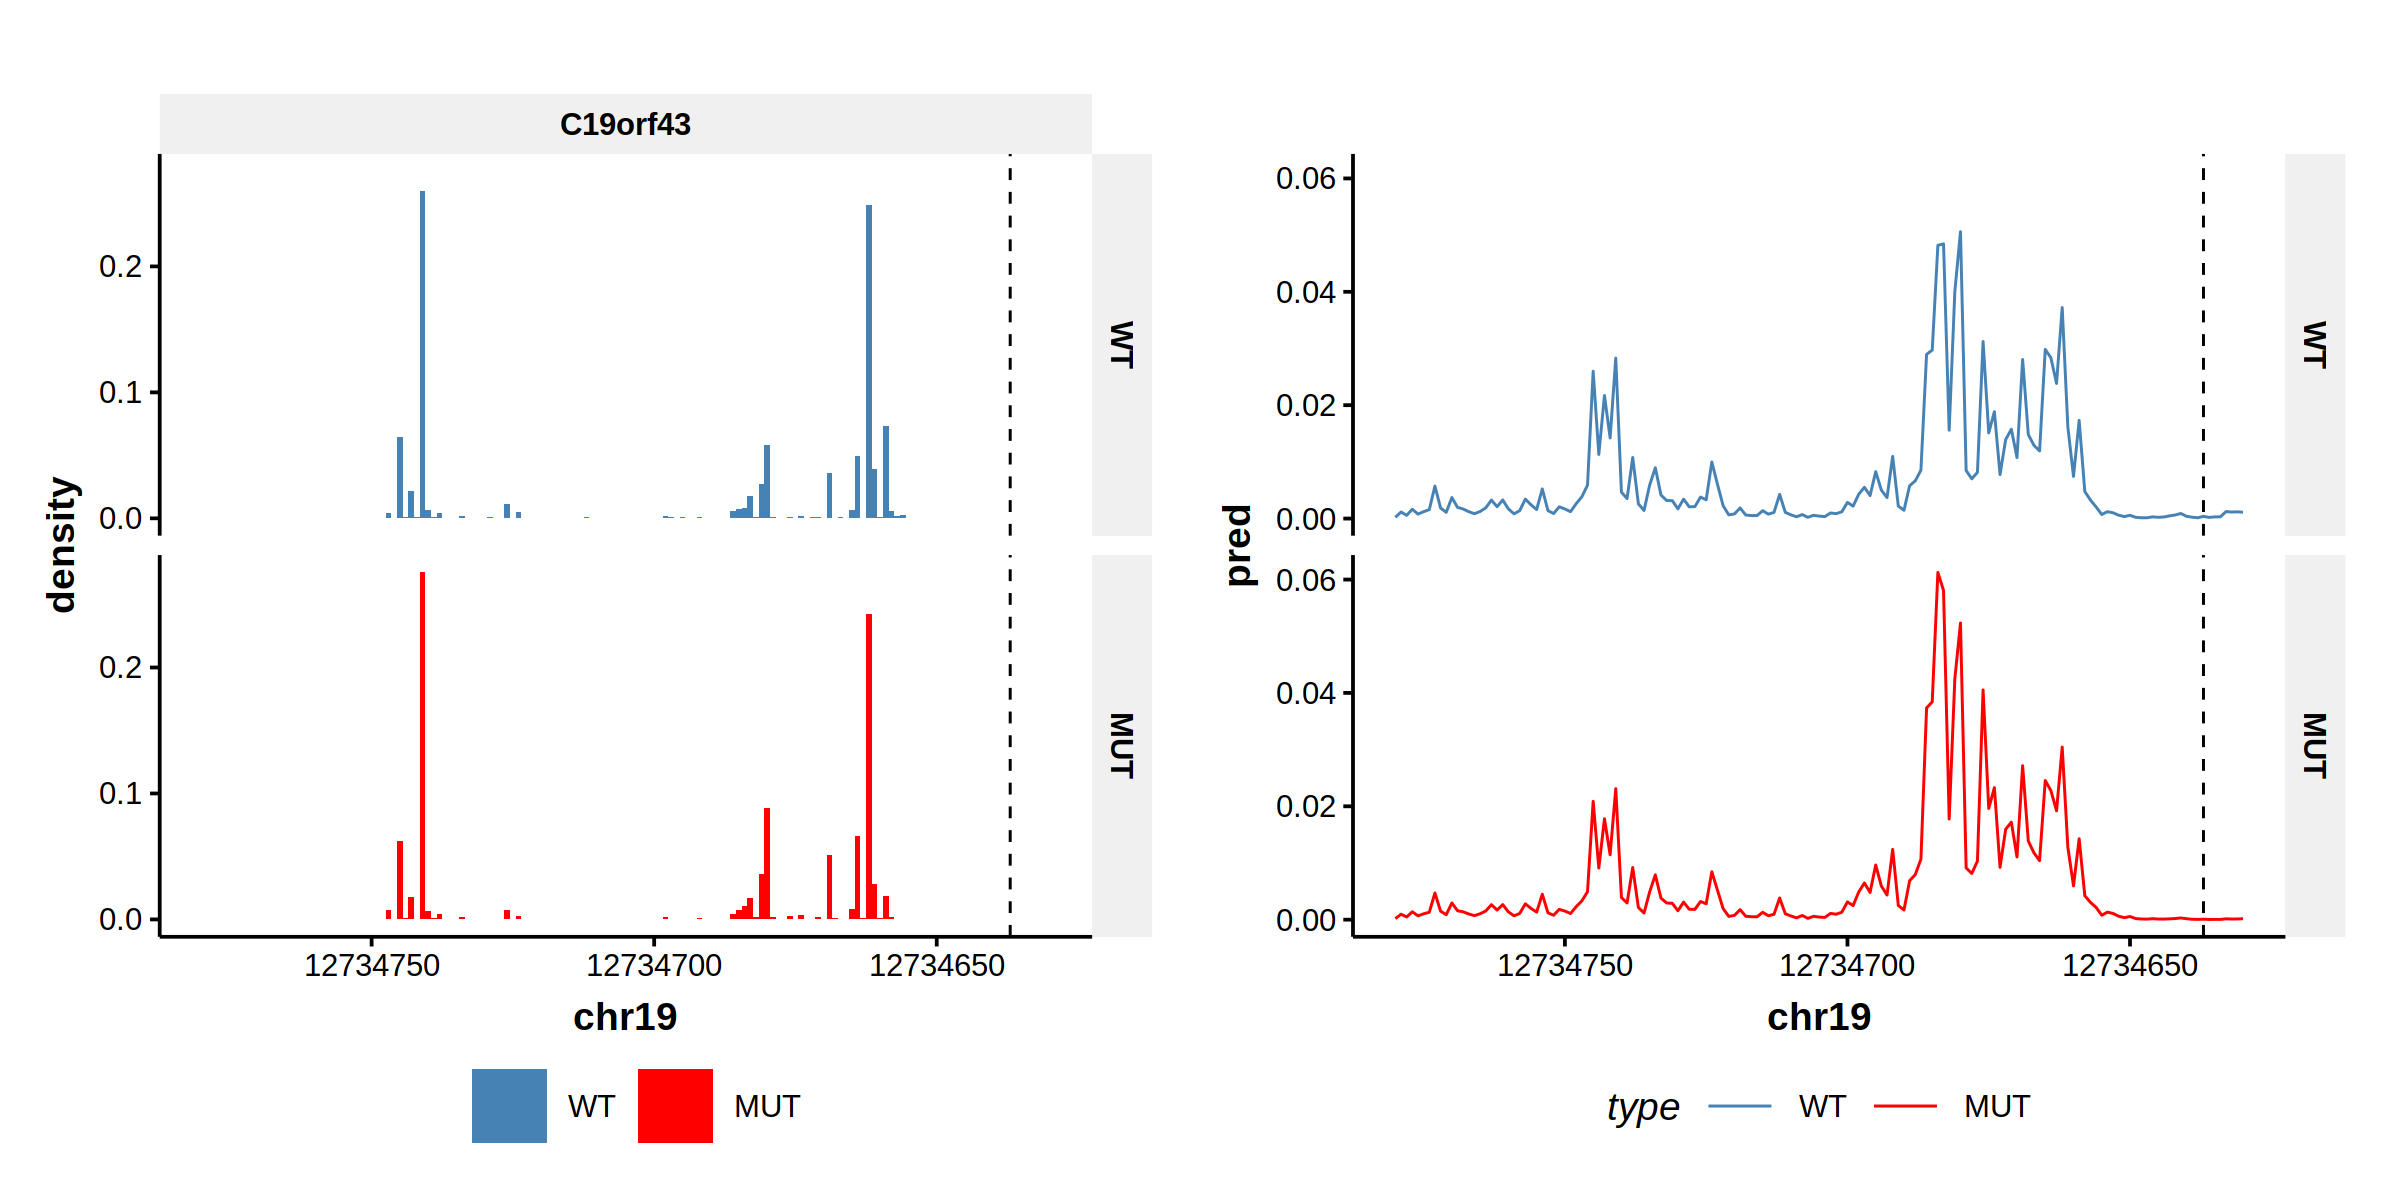

In [ ]:
%%R -w 12 -h 6 --unit in --res 200


#SP- negative example (slight increase effect)
p1 = ggplot(data[gene=='C19orf43'][ (delend<=12734681-36  & dellen >1 & dellen <20) |type=='WT']) +
    geom_histogram( aes(x=pos, y=..density.., fill=type),binwidth=1) +
    scale_fill_manual(values=c("steelblue", "red")) +
    labs(fill="")+facet_grid(type~gene)+geom_vline(xintercept=12734681-44, linetype=2)+coord_cartesian(xlim=(c(12734780, 12734630)))+xlab('chr19')+theme_Publication()
p1



plotdata = data.frame(pos = c( seq(12734681-100,12734681+99),  seq(12734681-100,12734681+99)),
                     pred = c(exp(pred_all[[11]])-1,  colMeans(exp(predmuts_all[[11]][ data[gene=='C19orf43' & type=='MUT'][,(delend<=12734681-36  & dellen >1 & dellen <20),], ])-1)),
                     #pred = c(pred_all[[11]],  colMeans(predmuts_all[[11]][ data[gene=='C19orf43' & type=='MUT'][,(delend<=12734681-36  & dellen >1 & dellen <20),], ]))),
                      type = factor(c(rep('WT',200), rep('MUT',200)), levels=c('WT','MUT')))


plotdata2 = data.table::copy(plotdata)
plotdata2 = plotdata2[plotdata2$pos>=12734630 & plotdata2$pos <=12734780,]
plotdata2$pred[plotdata2$type=='WT'] = plotdata2$pred[plotdata2$type=='WT'] / sum(plotdata2$pred[plotdata2$type=='WT'])
plotdata2$pred[plotdata2$type=='MUT'] = plotdata2$pred[plotdata2$type=='MUT'] / sum(plotdata2$pred[plotdata2$type=='MUT'])
p1p = ggplot(plotdata2)+geom_line(aes(x=pos,y=pred, color=type))+  scale_color_manual(values=c("steelblue", "red")) +
    labs(fill="")+facet_grid(type~.)+geom_vline(xintercept=12734681-44, linetype=2)+coord_cartesian(xlim=(c(12734780, 12734630)))+theme_Publication()+xlab('chr19')
p1q = ggplot(plotdata2)+geom_line(aes(x=pos,y=pred, color=type))+  scale_color_manual(values=c("steelblue", "red")) +
    labs(fill="")+geom_vline(xintercept=12734681-44, linetype=2)+coord_cartesian(xlim=(c(12734780, 12734630)))+theme_Publication()+xlab('chr19')


p1 + p1p

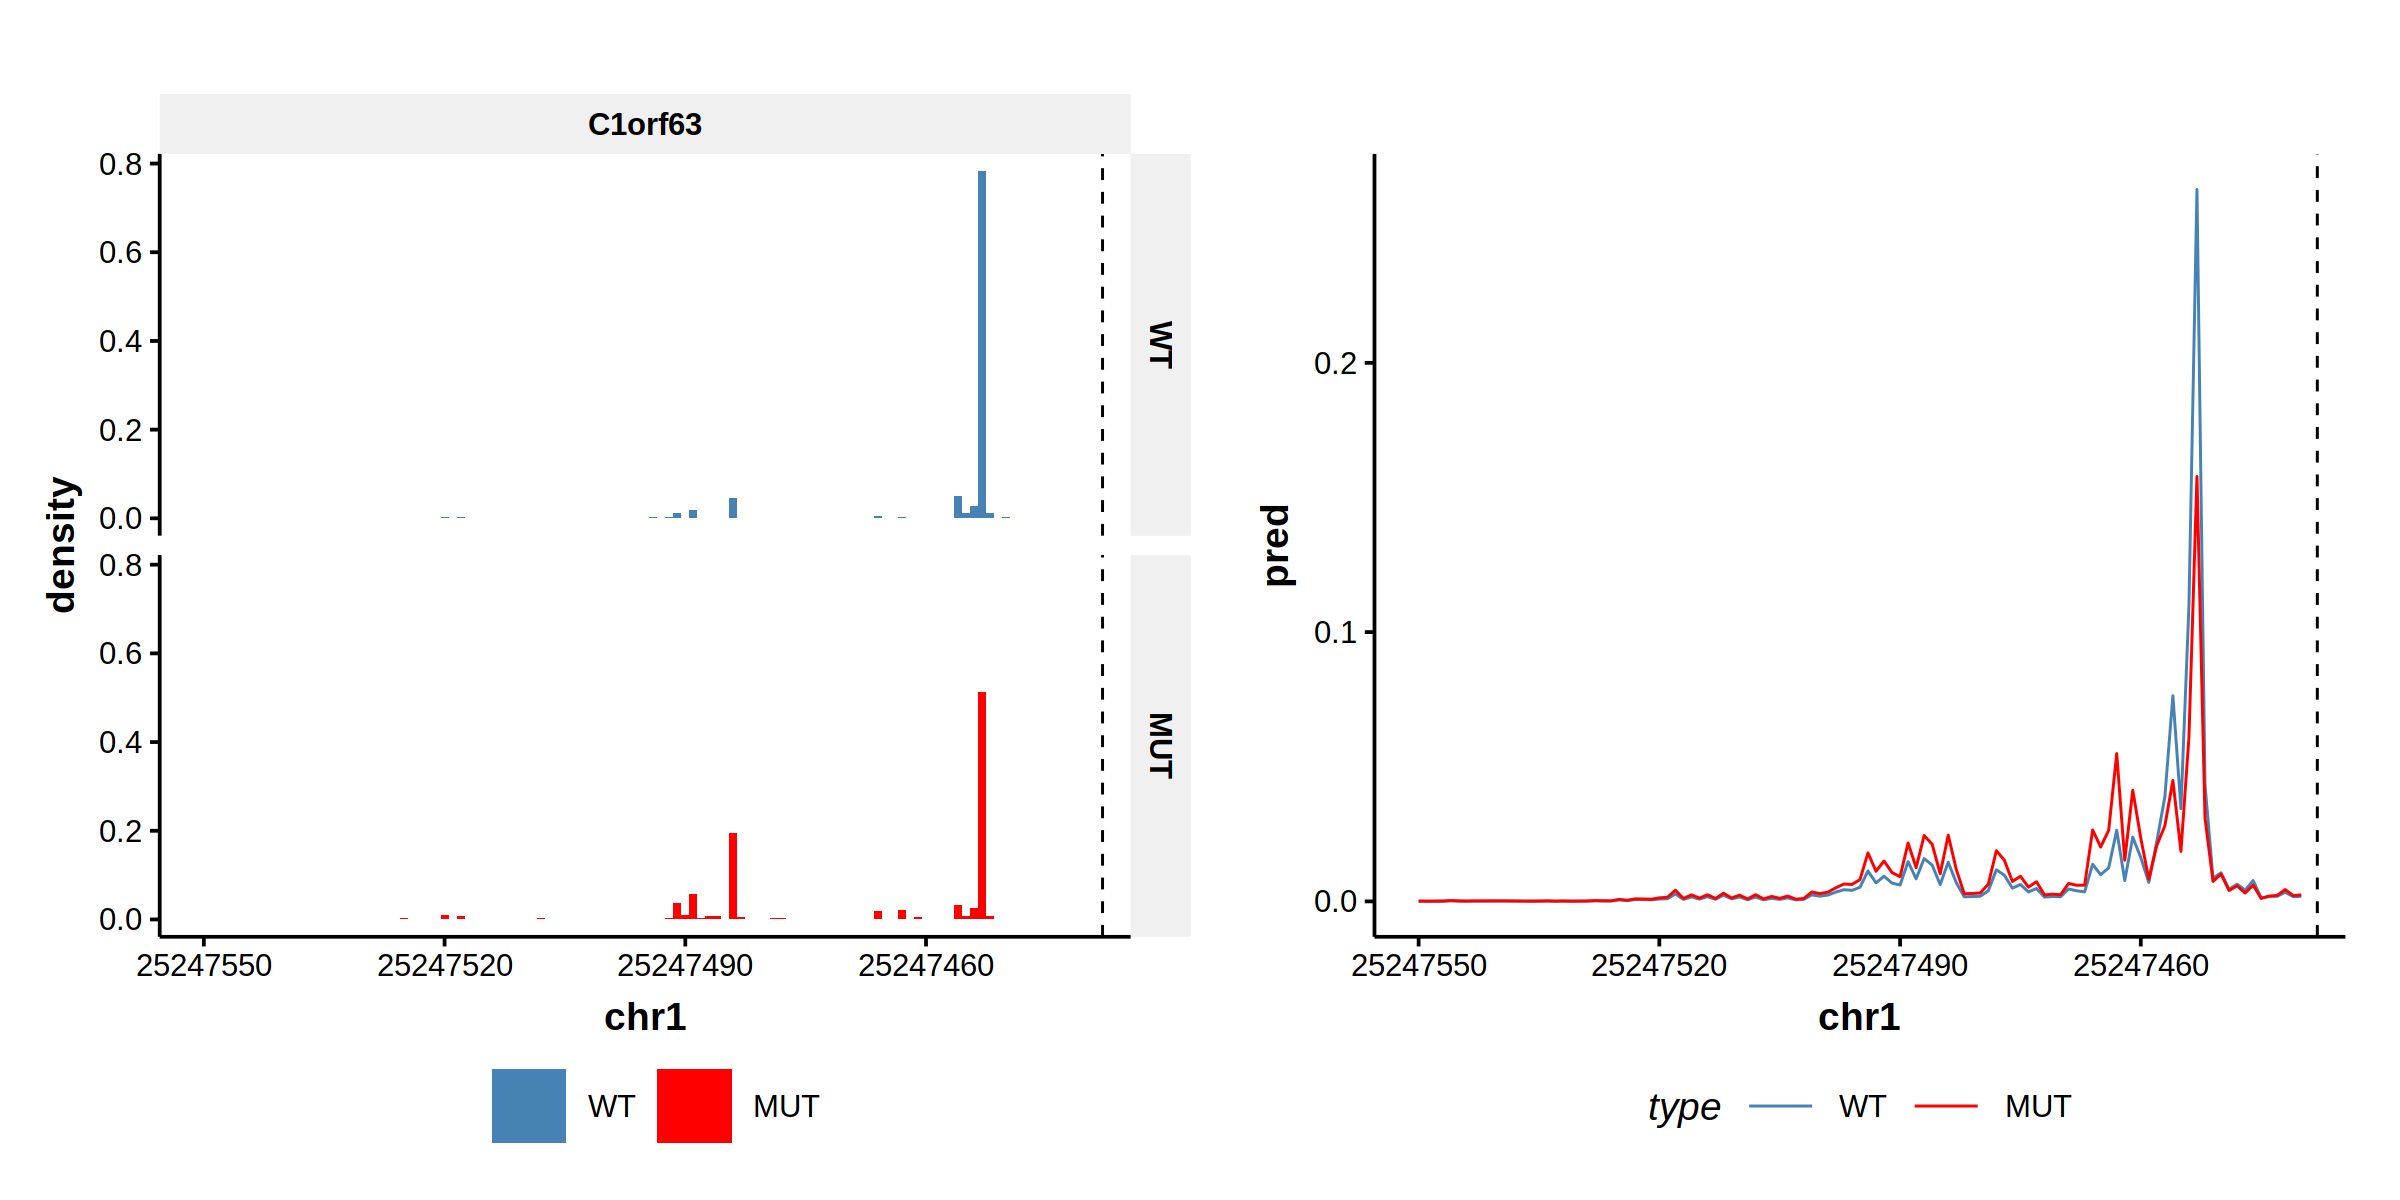

In [ ]:
%%R -w 12 -h 6 --unit in --res 200

#okish shift example, Long Inr
p2 = ggplot(data[gene=='C1orf63'][(delend<=25247453-15 & dellen >1 & dellen<20)|type=='WT']) +
    geom_histogram( aes(x=pos, y=..density.., fill=type),binwidth=1) +
    scale_fill_manual(values=c("steelblue", "red")) +
    labs(fill="")+facet_grid(type~gene)+geom_vline(xintercept=25247453-15, linetype=2)+coord_cartesian(xlim=(c(25247550, 25247440)))+xlab('chr1')+theme_Publication()
p2


plotdata = data.frame(pos = c( seq(25247453-100,25247453+99),  seq(25247453-100,25247453+99)),
                     pred = c(exp(pred_all[[2]])-1,  colMeans(exp(predmuts_all[[2]][ data[gene=='C1orf63' & type=='MUT'][,(delend<=25247453-15 & dellen >1 & dellen<20),], ])-1)),
                     #pred = c(pred_all[[2]],  colMeans(predmuts_all[[2]][ data[gene=='C1orf63' & type=='MUT'][,(delend<=25247453-15 & dellen >1 & dellen<20),], ])),
                      type = factor(c(rep('WT',200), rep('MUT',200)), levels=c('WT','MUT')))


plotdata2 = data.table::copy(plotdata)
plotdata2 = plotdata2[plotdata2$pos>=25247440 & plotdata2$pos <=25247550,]
plotdata2$pred[plotdata2$type=='WT'] = plotdata2$pred[plotdata2$type=='WT'] / sum(plotdata2$pred[plotdata2$type=='WT'])
plotdata2$pred[plotdata2$type=='MUT'] = plotdata2$pred[plotdata2$type=='MUT'] / sum(plotdata2$pred[plotdata2$type=='MUT'])
p2p = ggplot(plotdata2)+geom_line(aes(x=pos,y=pred, color=type))+  scale_color_manual(values=c("steelblue", "red")) +
    labs(fill="")+facet_grid(type~.)+geom_vline(xintercept=25247453-15, linetype=2)+coord_cartesian(xlim=(c(25247550, 25247440)))+theme_Publication()+xlab('chr1')
p2q = ggplot(plotdata2)+geom_line(aes(x=pos,y=pred, color=type))+  scale_color_manual(values=c("steelblue", "red")) +
    labs(fill="")+geom_vline(xintercept=25247453-15, linetype=2)+coord_cartesian(xlim=(c(25247550, 25247440)))+theme_Publication()+xlab('chr1')


p2 + p2q

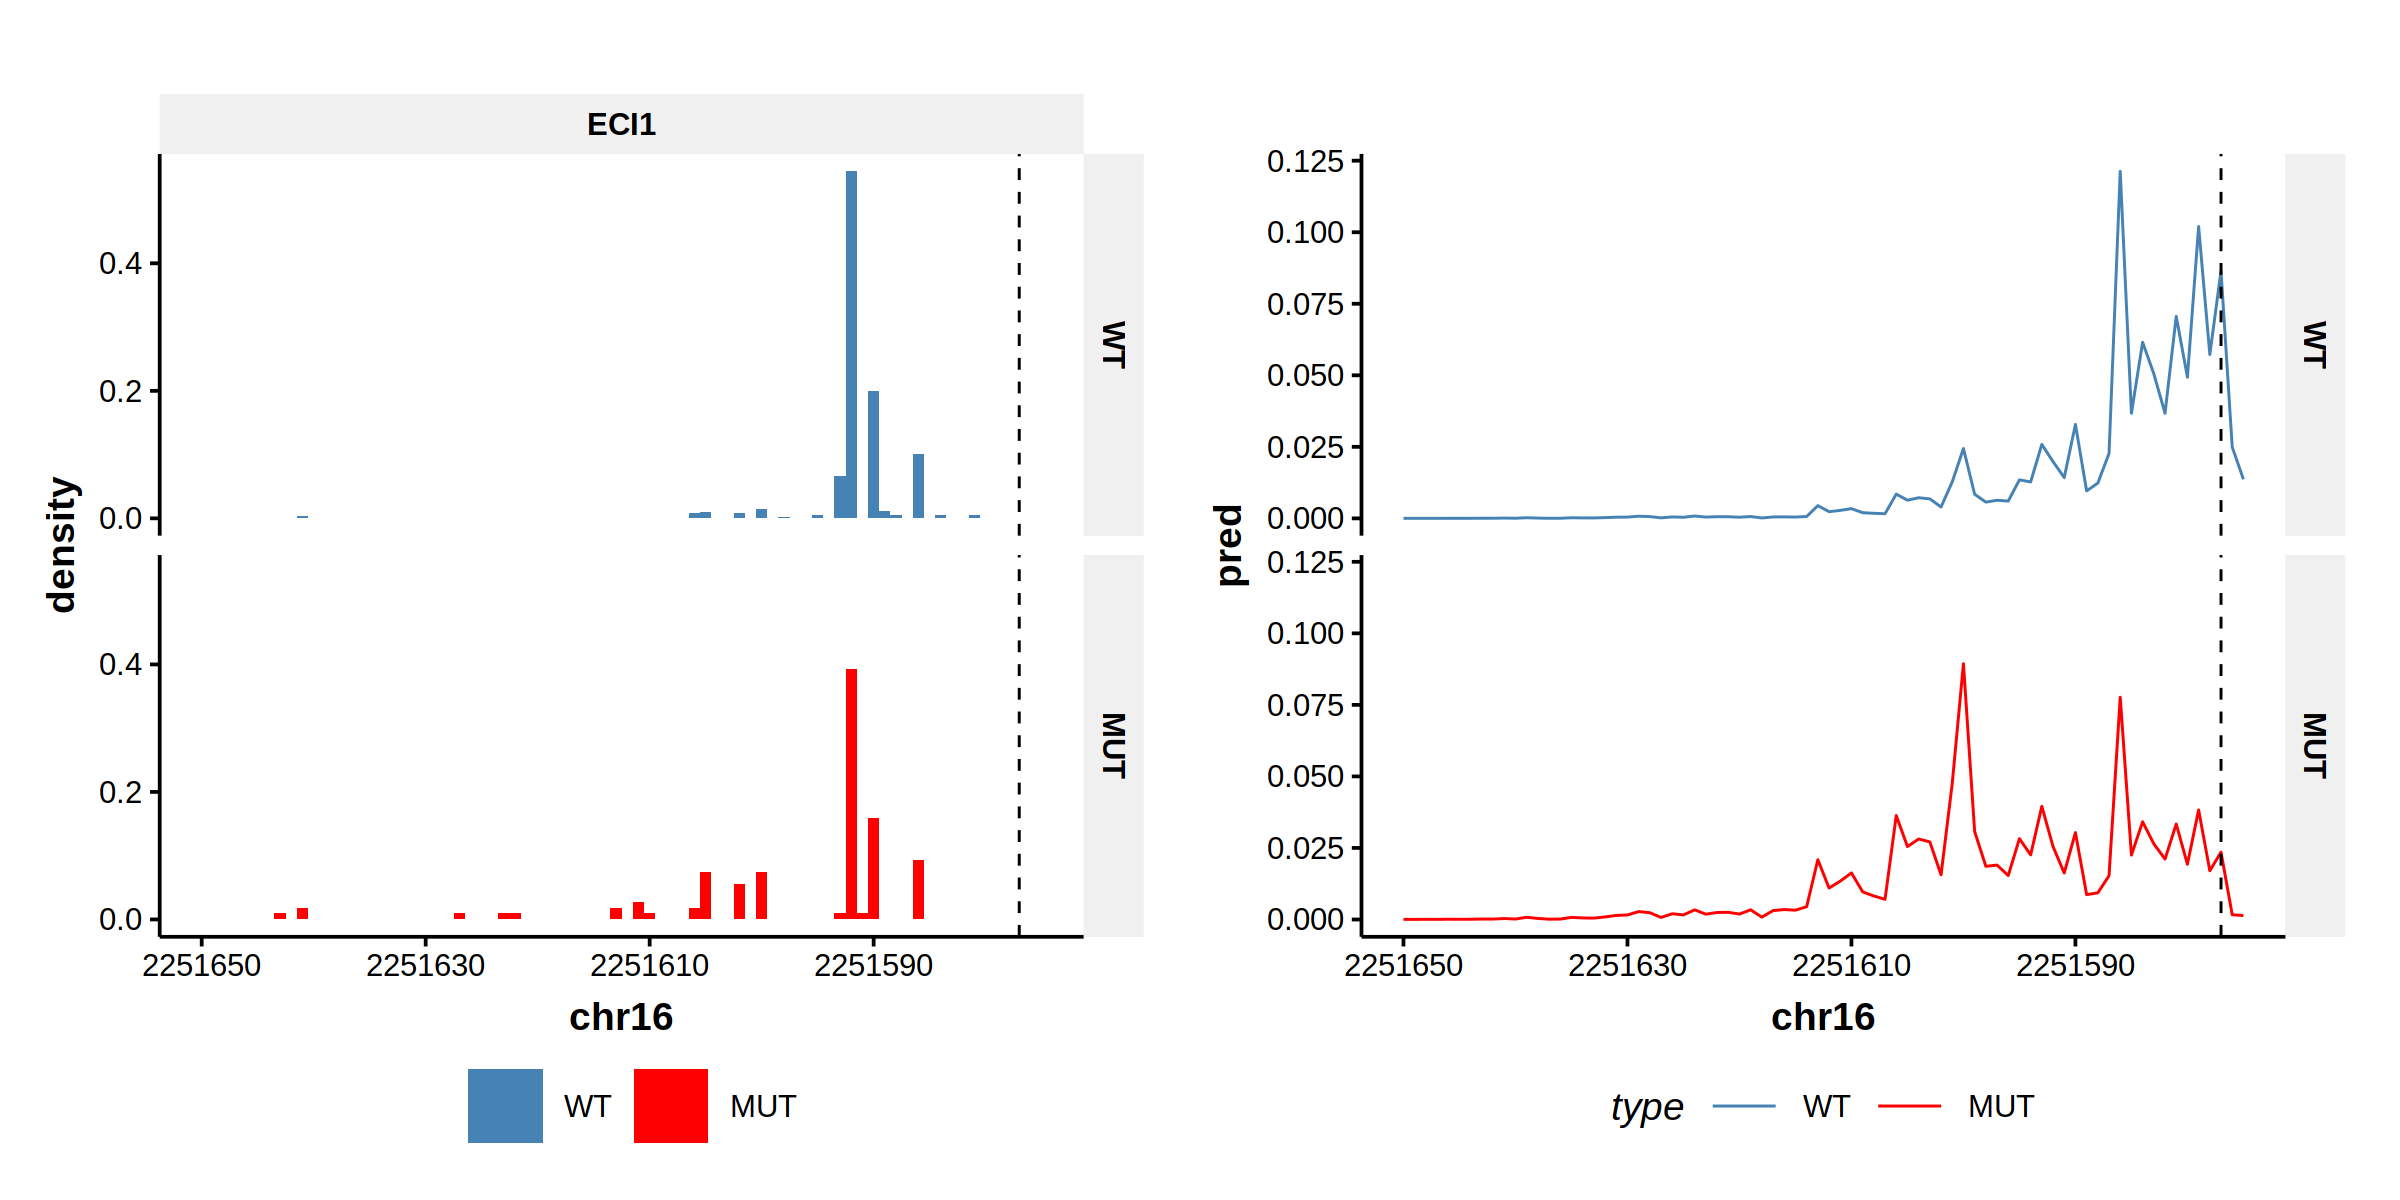

In [ ]:
%%R -w 12 -h 6 --unit in --res 200
#this is hard to analyze as deletion overlapping with to non-peak tss signal , YY1 motif shift 
p3 = ggplot(data[gene=='ECI1'][(dellen >10 & dellen<20)|type=='WT']) +
    geom_histogram( aes(x=pos, y=..density.., fill=type),binwidth=1) +
    scale_fill_manual(values=c("steelblue", "red")) +
    labs(fill="")+facet_grid(type~gene)+geom_vline(xintercept=2251586-9, linetype=2)+coord_cartesian(xlim=(c(2251650, 2251575)))+theme_Publication()+xlab('chr16')
p3



plotdata = data.frame(pos = c( seq(2251586-100,2251586+99),  seq(2251586-100,2251586+99)),
                     pred = c(exp(pred_all[[12]])-1,  colMeans(exp(predmuts_all[[12]][ data[gene=='ECI1' & type=='MUT'][,(dellen >10 & dellen<20),], ])-1)),
                     #pred = c(pred_all[[1]],  colMeans(predmuts_all[[1]][ data[gene=='HIST1H1D' & type=='MUT'][,delend<=26234986-12,], ])),
                      type = factor(c(rep('WT',200), rep('MUT',200)), levels=c('WT','MUT')))


plotdata2 = data.table::copy(plotdata)
plotdata2 = plotdata2[plotdata2$pos>=2251575 & plotdata2$pos <=2251650,]
plotdata2$pred[plotdata2$type=='WT'] = plotdata2$pred[plotdata2$type=='WT'] / sum(plotdata2$pred[plotdata2$type=='WT'])
plotdata2$pred[plotdata2$type=='MUT'] = plotdata2$pred[plotdata2$type=='MUT'] / sum(plotdata2$pred[plotdata2$type=='MUT'])
p3p = ggplot(plotdata2)+geom_line(aes(x=pos,y=pred, color=type))+  scale_color_manual(values=c("steelblue", "red")) +
    labs(fill="")+facet_grid(type~.)+geom_vline(xintercept=2251586-9, linetype=2)+coord_cartesian(xlim=(c(2251650, 2251575)))+theme_Publication()+xlab('chr16')
p3q = ggplot(plotdata2)+geom_line(aes(x=pos,y=pred, color=type))+  scale_color_manual(values=c("steelblue", "red")) +
    labs(fill="")+geom_vline(xintercept=2251586-9, linetype=2)+coord_cartesian(xlim=(c(2251650, 2251575)))+theme_Publication()+xlab('chr16')

p3+p3p

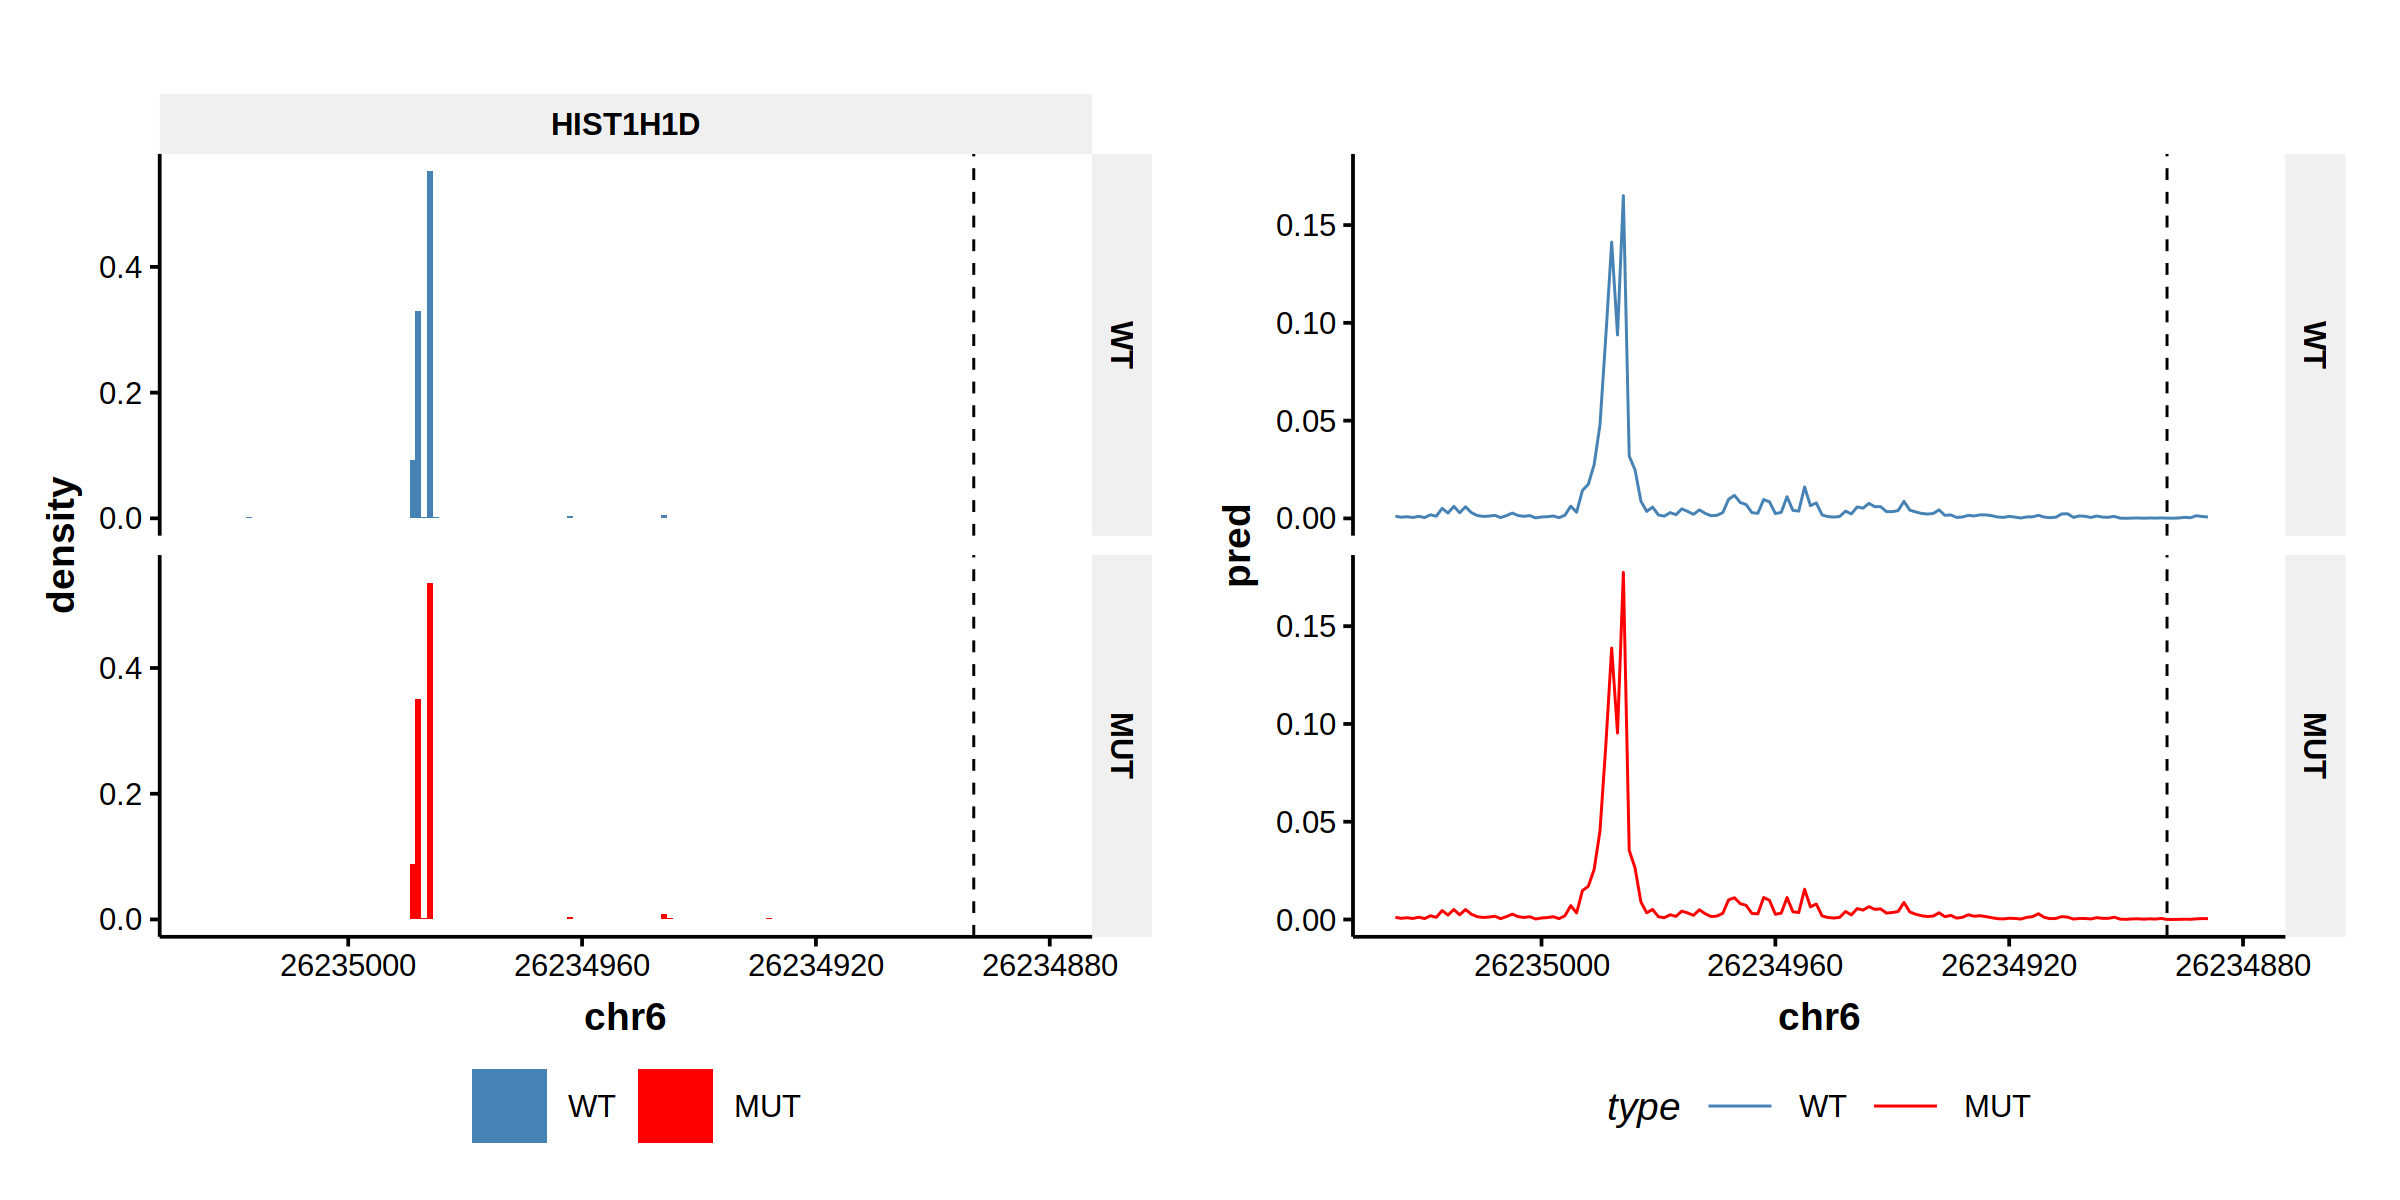

In [ ]:
%%R -w 12 -h 6 --unit in --res 200

#good negative example Long Inr
p5 = ggplot(data[gene=='HIST1H1D'][(delend<=26234986-12 & dellen >1 & dellen<20)|type=='WT']) +
    geom_histogram( aes(x=pos, y=..density.., fill=type),binwidth=1) +
    scale_fill_manual(values=c("steelblue", "red")) +
    labs(fill="")+facet_grid(type~gene)+geom_vline(xintercept=26234986-93, linetype=2)+coord_cartesian(xlim=rev(c(26234880,26235025)))+theme_Publication()+xlab('chr6')
p5

plotdata = data.frame(pos = c( seq(26234986-100,26234986+99),  seq(26234986-100,26234986+99)),
                     pred = c(exp(pred_all[[1]])-1,  colMeans(exp(predmuts_all[[1]][ data[gene=='HIST1H1D' & type=='MUT'][,(delend<=26234986-12 & dellen >1 & dellen<20),], ])-1)),
                     #pred = c(pred_all[[1]],  colMeans(predmuts_all[[1]][ data[gene=='HIST1H1D' & type=='MUT'][,delend<=26234986-12,], ])),
                      type = factor(c(rep('WT',200), rep('MUT',200)), levels=c('WT','MUT')))

plotdata2 = data.table::copy(plotdata)
plotdata2 = plotdata2[plotdata2$pos>=26234880 & plotdata2$pos <=26235025,]
plotdata2$pred[plotdata2$type=='WT'] = plotdata2$pred[plotdata2$type=='WT'] / sum(plotdata2$pred[plotdata2$type=='WT'])
plotdata2$pred[plotdata2$type=='MUT'] = plotdata2$pred[plotdata2$type=='MUT'] / sum(plotdata2$pred[plotdata2$type=='MUT'])

p5p = ggplot(plotdata2)+geom_line(aes(x=pos,y=pred, color=type))+  scale_color_manual(values=c("steelblue", "red")) +
    labs(fill="")+facet_grid(type~.)+geom_vline(xintercept=26234986-93, linetype=2)+coord_cartesian(xlim=rev(c(26234880,26235025)))+theme_Publication()+xlab('chr6')
p5q = ggplot(plotdata2)+geom_line(aes(x=pos,y=pred, color=type))+  scale_color_manual(values=c("steelblue", "red")) +
    labs(fill="")+geom_vline(xintercept=26234986-93, linetype=2)+coord_cartesian(xlim=rev(c(26234880,26235025)))+theme_Publication()+xlab('chr6')

p5+p5p

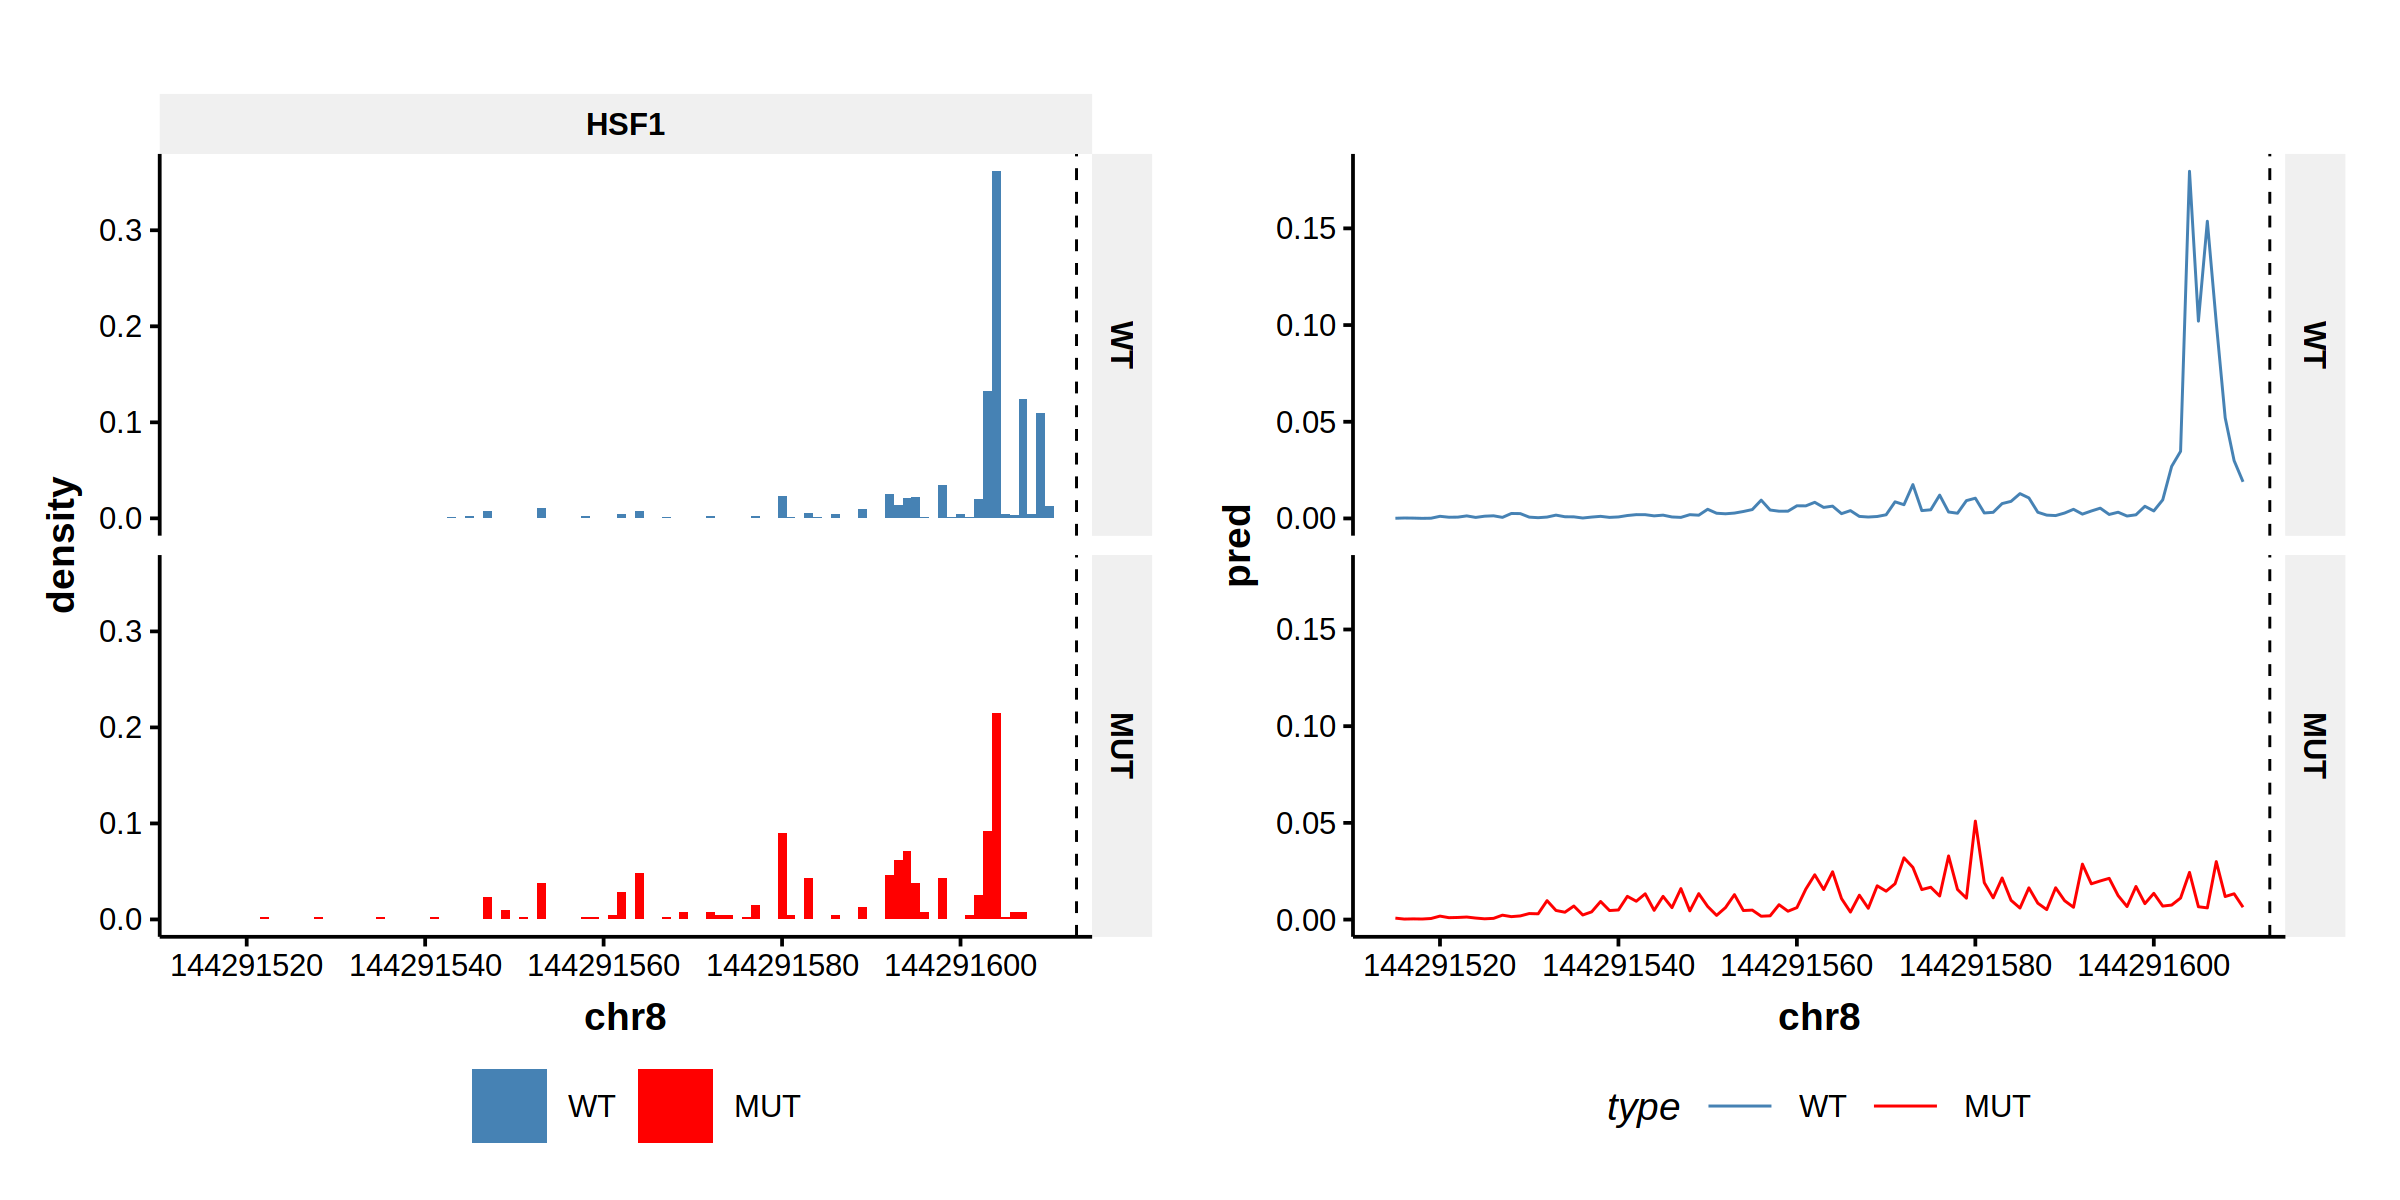

In [ ]:
%%R -w 12 -h 6 --unit in --res 200

#good example of shift YY1
p6 = ggplot(data[gene=='HSF1'][((delstart>=144291604+5)& dellen>1 & dellen<20)|type=='WT']) +
    geom_histogram( aes(x=pos, y=..density.., fill=type),binwidth=1) +
    scale_fill_manual(values=c("steelblue", "red")) +
    labs(fill="")+facet_grid(type~gene)+geom_vline(xintercept=144291604+9, linetype=2)+coord_cartesian(xlim=c(144291515,144291610))+theme_Publication()+xlab('chr8')
p6



plotdata = data.frame(pos = c( seq(144291604-100,144291604+99),  seq(144291604-100,144291604+99)),
                     pred = c(exp(pred_all[[1]])-1,  colMeans(exp(predmuts_all[[8]][ data[gene=='HSF1' & type=='MUT'][,((delstart>=144291604+5) & dellen>1 & dellen<20),], ])-1)),
                     #pred = c(pred_all[[1]],  colMeans(predmuts_all[[1]][ data[gene=='HIST1H1D' & type=='MUT'][,delend<=26234986-12,], ])),
                      type = factor(c(rep('WT',200), rep('MUT',200)), levels=c('WT','MUT')))


plotdata2 = data.table::copy(plotdata)
plotdata2 = plotdata2[plotdata2$pos>=144291515 & plotdata2$pos <=144291610,]
plotdata2$pred[plotdata2$type=='WT'] = plotdata2$pred[plotdata2$type=='WT'] / sum(plotdata2$pred[plotdata2$type=='WT'])
plotdata2$pred[plotdata2$type=='MUT'] = plotdata2$pred[plotdata2$type=='MUT'] / sum(plotdata2$pred[plotdata2$type=='MUT'])
p6p = ggplot(plotdata2)+geom_line(aes(x=pos,y=pred, color=type))+  scale_color_manual(values=c("steelblue", "red")) +
    labs(fill="")+facet_grid(type~.)+geom_vline(xintercept=144291604+9, linetype=2)+coord_cartesian(xlim=c(144291515,144291610))+theme_Publication()+xlab('chr8')
p6q = ggplot(plotdata2)+geom_line(aes(x=pos,y=pred, color=type))+  scale_color_manual(values=c("steelblue", "red")) +
    labs(fill="")+geom_vline(xintercept=144291604+9, linetype=2)+coord_cartesian(xlim=c(144291515,144291610))+theme_Publication()+xlab('chr8')

p6+p6p


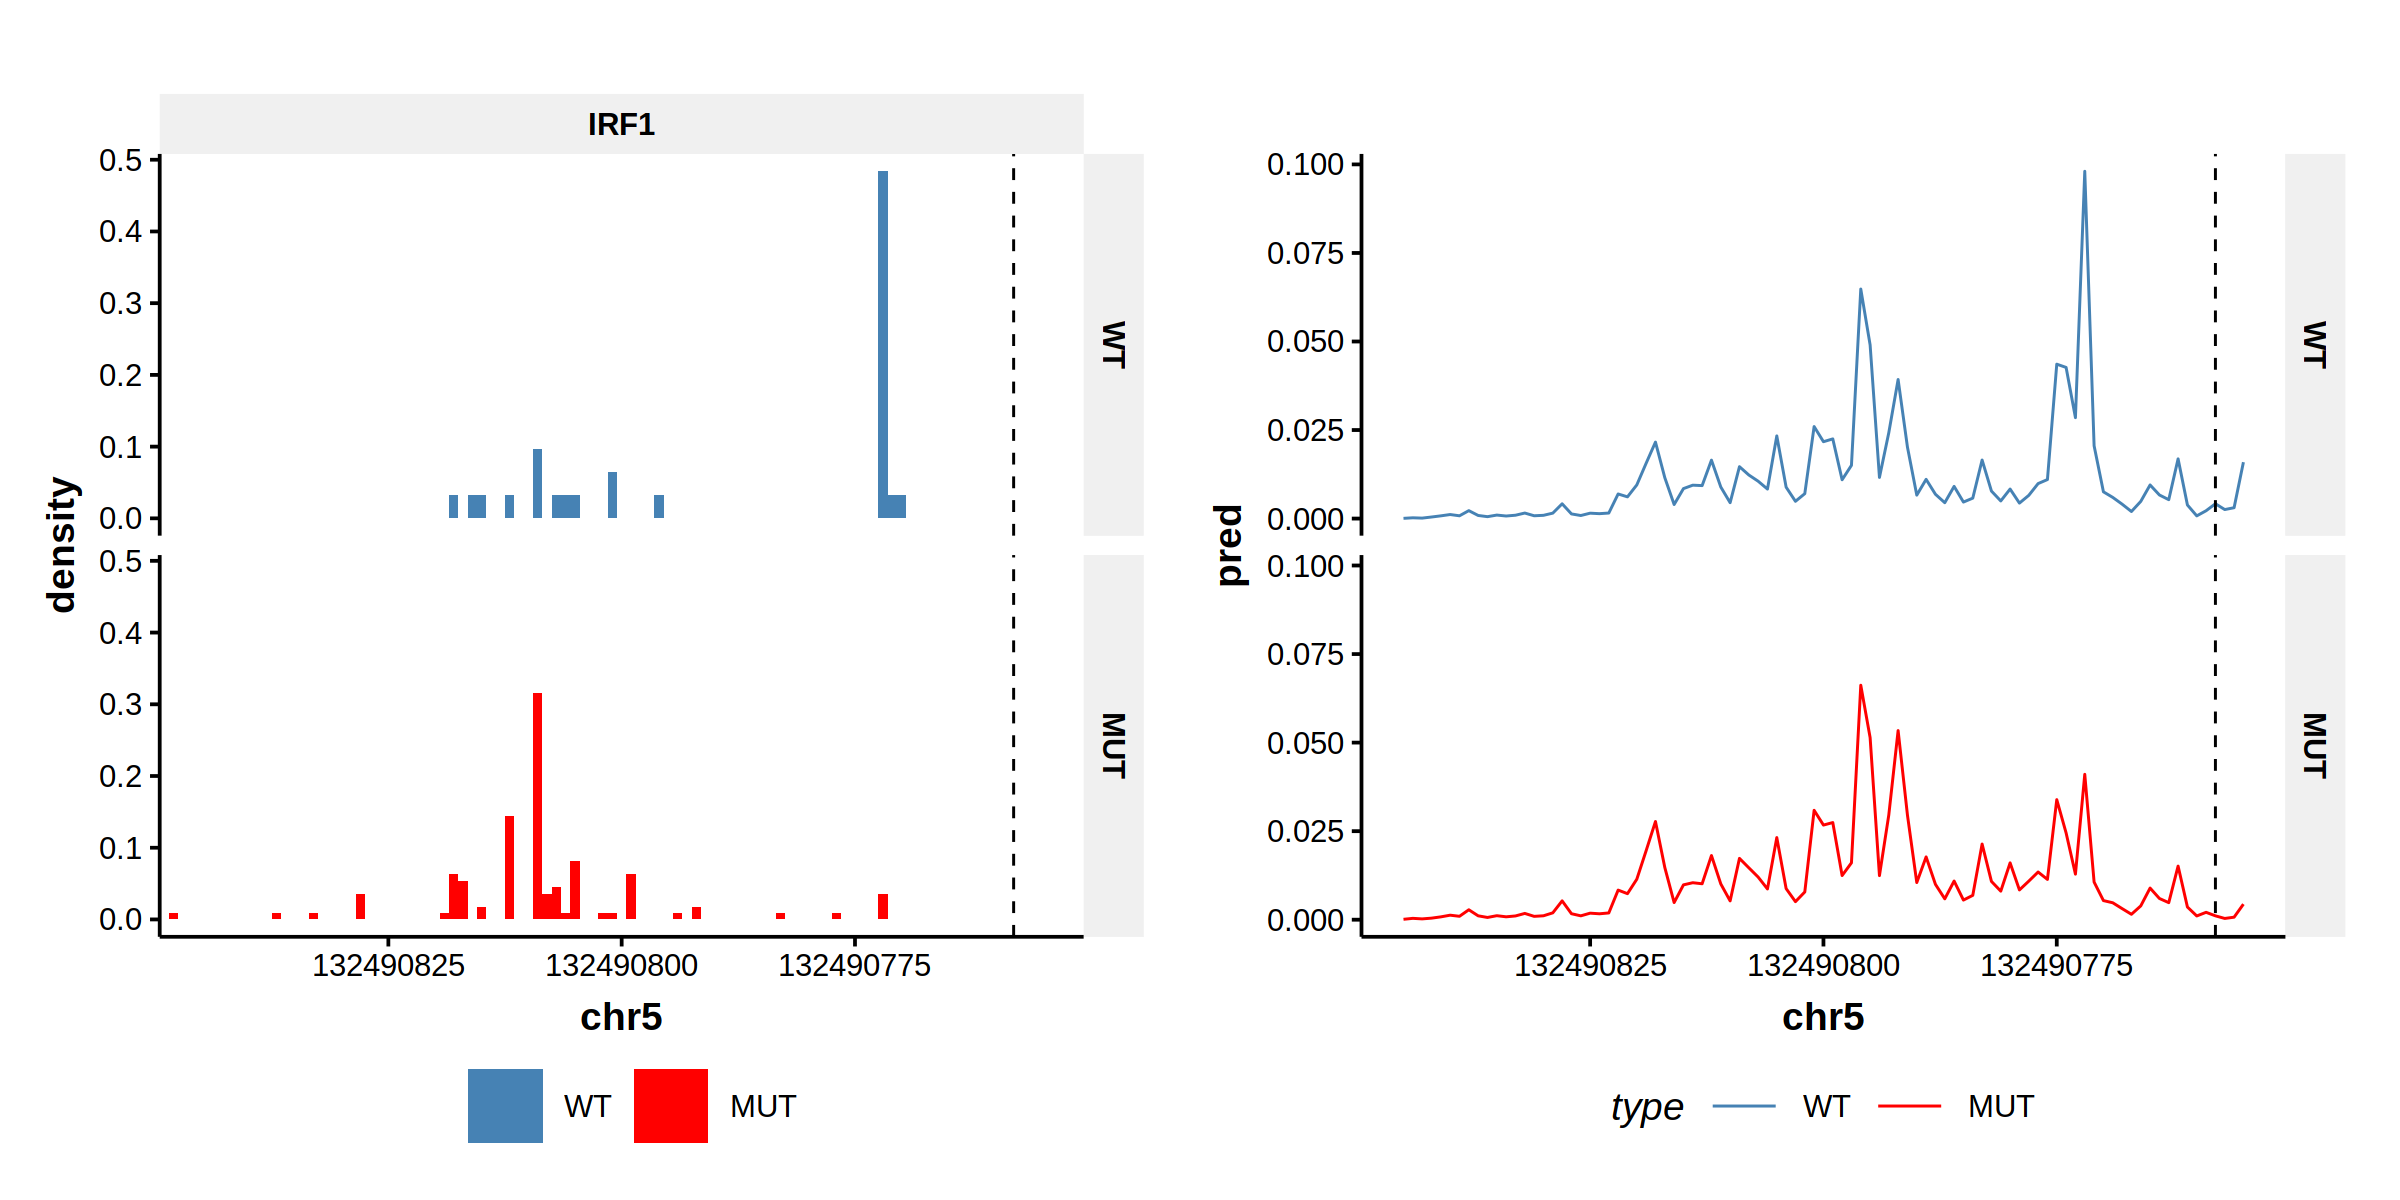

In [ ]:
%%R -w 12 -h 6 --unit in --res 200

#goodish example of shift Long Inr
p7 = ggplot(data[gene=='IRF1'][((delend<=132490772-12)& dellen>1 & dellen<20)|type=='WT']) +
    geom_histogram( aes(x=pos, y=..density.., fill=type),binwidth=1) +
    scale_fill_manual(values=c("steelblue", "red")) +
    labs(fill="")+facet_grid(type~gene)+geom_vline(xintercept=132490772-14, linetype=2)+coord_cartesian(xlim=c(132490845,132490755))+theme_Publication()+xlab('chr5')
p7


plotdata = data.frame(pos = c( seq(132490772-100,132490772+99),  seq(132490772-100,132490772+99)),
                     pred = c(exp(pred_all[[5]])-1,  colMeans(exp(predmuts_all[[5]][ data[gene=='IRF1' & type=='MUT'][,((delend<=132490772-12)& dellen>1 & dellen<20),], ])-1)),
                     #pred = c(pred_all[[1]],  colMeans(predmuts_all[[1]][ data[gene=='HIST1H1D' & type=='MUT'][,delend<=26234986-12,], ])),
                      type = factor(c(rep('WT',200), rep('MUT',200)), levels=c('WT','MUT')))


plotdata2 = data.table::copy(plotdata)
plotdata2 = plotdata2[plotdata2$pos>=132490755 & plotdata2$pos <=132490845,]
plotdata2$pred[plotdata2$type=='WT'] = plotdata2$pred[plotdata2$type=='WT'] / sum(plotdata2$pred[plotdata2$type=='WT'])
plotdata2$pred[plotdata2$type=='MUT'] = plotdata2$pred[plotdata2$type=='MUT'] / sum(plotdata2$pred[plotdata2$type=='MUT'])
p7p = ggplot(plotdata2)+geom_line(aes(x=pos,y=pred, color=type))+  scale_color_manual(values=c("steelblue", "red")) +
    labs(fill="")+facet_grid(type~.)+geom_vline(xintercept=132490772-14, linetype=2)+coord_cartesian(xlim=c(132490845,132490755))+theme_Publication()+xlab('chr5')
p7q = ggplot(plotdata2)+geom_line(aes(x=pos,y=pred, color=type))+  scale_color_manual(values=c("steelblue", "red")) +
    labs(fill="")+geom_vline(xintercept=132490772-14, linetype=2)+coord_cartesian(xlim=c(132490845,132490755))+theme_Publication()+xlab('chr5')

p7+p7p


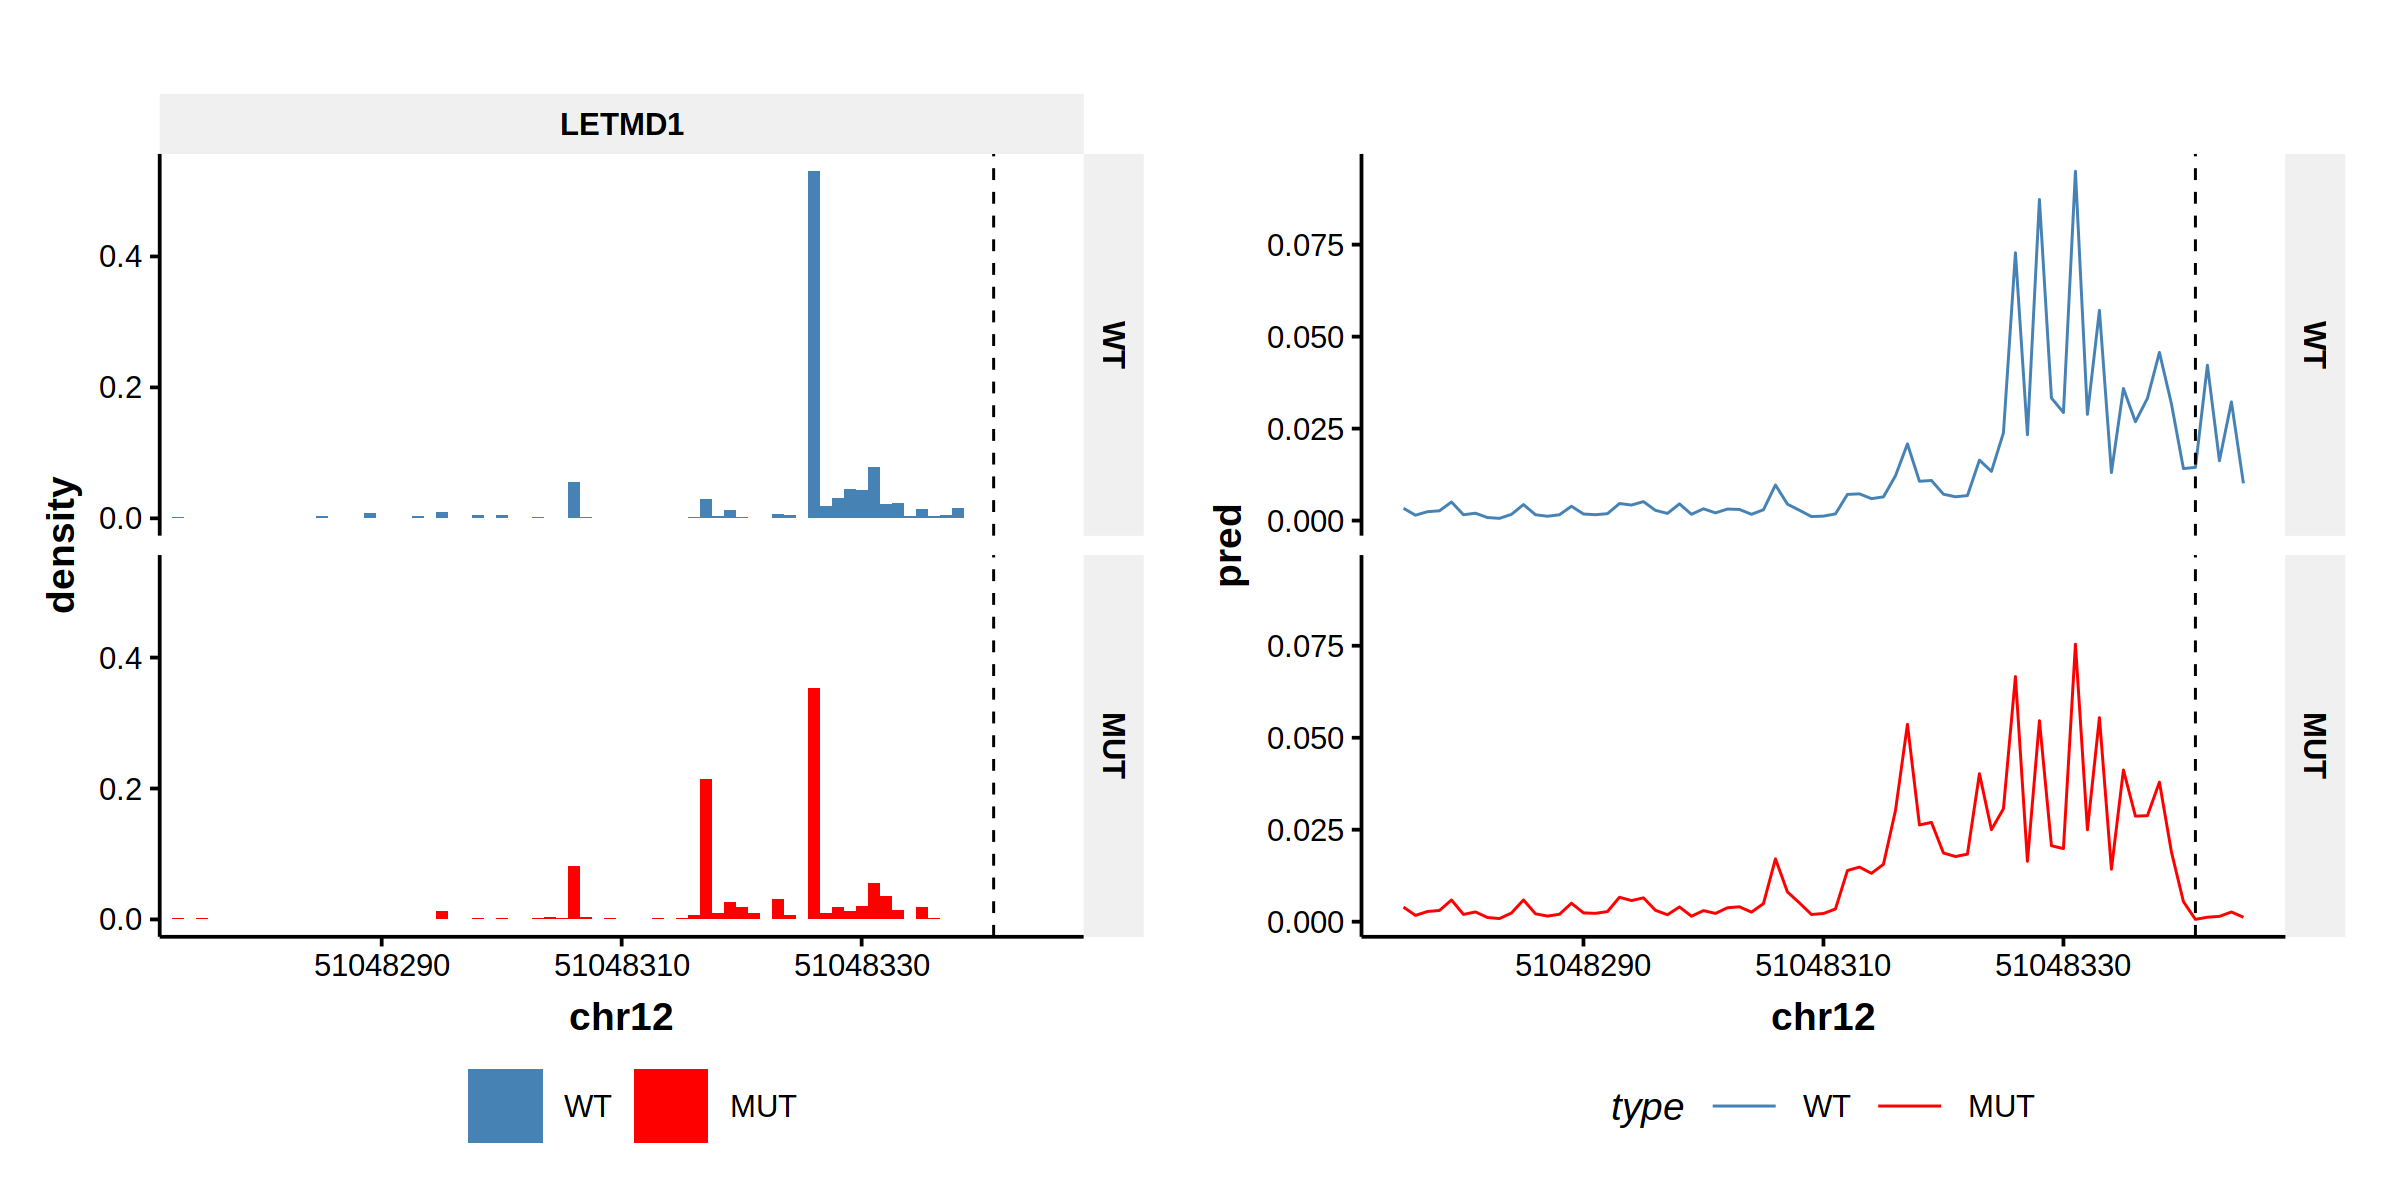

In [ ]:
%%R -w 12 -h 6 --unit in --res 200



#this is hard to analyze as deletion overlapping with to non-peak tss signal , YY1 motif shift 
p8 = ggplot(data[gene=='LETMD1'][((delstart>=51048340) & dellen>1 & dellen<20)|type=='WT']) +
    geom_histogram( aes(x=pos, y=..density.., fill=type),binwidth=1) +
    scale_fill_manual(values=c("steelblue", "red")) +
    labs(fill="")+facet_grid(type~gene)+geom_vline(xintercept=51048326+15, linetype=2)+coord_cartesian(xlim=c(51048275,51048345))+xlab('chr12')+theme_Publication()
p8


plotdata = data.frame(pos = c( seq(51048326-100,51048326+99),  seq(51048326-100,51048326+99)),
                     pred = c(exp(pred_all[[13]])-1,  colMeans(exp(predmuts_all[[13]][ data[gene=='LETMD1' & type=='MUT'][,((delstart>=51048340) & dellen>1 & dellen<20),], ])-1)),
                     #pred = c(pred_all[[1]],  colMeans(predmuts_all[[1]][ data[gene=='HIST1H1D' & type=='MUT'][,delend<=26234986-12,], ])),
                      type = factor(c(rep('WT',200), rep('MUT',200)), levels=c('WT','MUT')))


plotdata2 = data.table::copy(plotdata)
plotdata2 = plotdata2[plotdata2$pos>=51048275 & plotdata2$pos <=51048345,]
plotdata2$pred[plotdata2$type=='WT'] = plotdata2$pred[plotdata2$type=='WT'] / sum(plotdata2$pred[plotdata2$type=='WT'])
plotdata2$pred[plotdata2$type=='MUT'] = plotdata2$pred[plotdata2$type=='MUT'] / sum(plotdata2$pred[plotdata2$type=='MUT'])
p8p = ggplot(plotdata2)+geom_line(aes(x=pos,y=pred, color=type))+  scale_color_manual(values=c("steelblue", "red")) +
    labs(fill="")+facet_grid(type~.)+geom_vline(xintercept=51048326+15, linetype=2)+coord_cartesian(xlim=c(51048275,51048345))+theme_Publication()+xlab('chr12')
p8q = ggplot(plotdata2)+geom_line(aes(x=pos,y=pred, color=type))+  scale_color_manual(values=c("steelblue", "red")) +
    labs(fill="")+geom_vline(xintercept=51048326+15, linetype=2)+coord_cartesian(xlim=c(51048275,51048345))+theme_Publication()+xlab('chr12')

p8+p8p


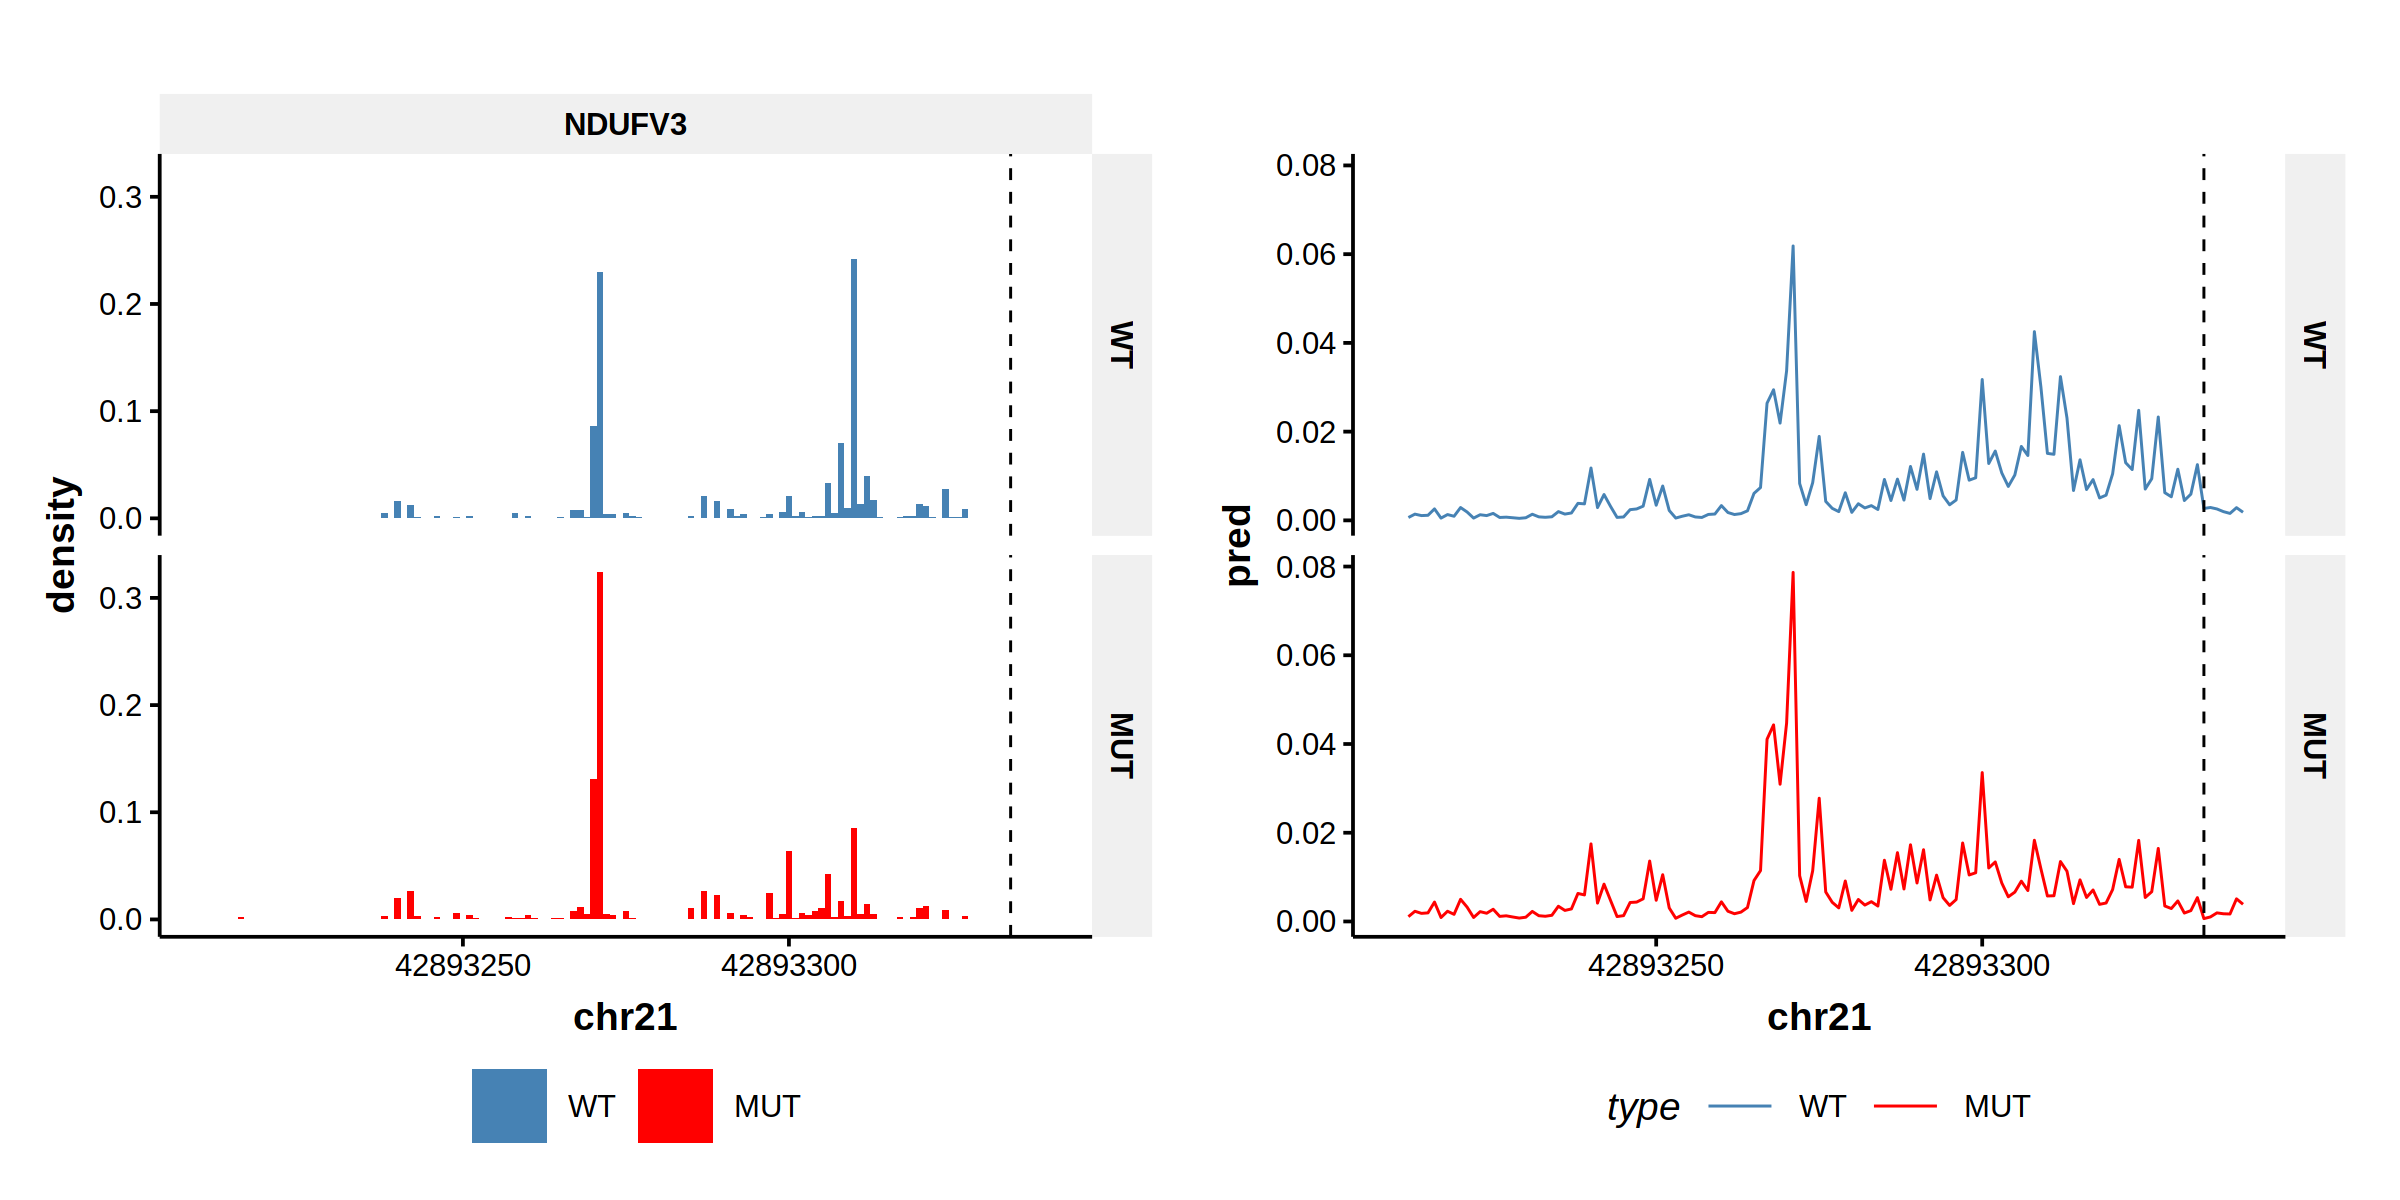

In [ ]:
%%R -w 12 -h 6 --unit in --res 200

#good example of shift YY1
p9 = ggplot(data[gene=='NDUFV3'][((delstart>=42893312+12)& dellen>1 & dellen<20)|type=='WT']) +
    geom_histogram( aes(x=pos, y=..density.., fill=type),binwidth=1) +
    scale_fill_manual(values=c("steelblue", "red")) +
    labs(fill="")+facet_grid(type~gene)+geom_vline(xintercept=42893312+22, linetype=2)+xlab('chr21')+coord_cartesian(xlim=c(42893210,42893340))+theme_Publication()
p9


plotdata = data.frame(pos = c( seq(42893312-100,42893312+99),  seq(42893312-100,42893312+99)),
                     pred = c(exp(pred_all[[7]])-1,  colMeans(exp(predmuts_all[[7]][ data[gene=='NDUFV3' & type=='MUT'][,((delstart>=42893312+12)& dellen>1 & dellen<20),], ])-1)),
                     #pred = c(pred_all[[7]],  colMeans(predmuts_all[[7]][ data[gene=='NDUFV3' & type=='MUT'][,((delstart>=42893312+12)& dellen>1 & dellen<20),], ])),
                      type = factor(c(rep('WT',200), rep('MUT',200)), levels=c('WT','MUT')))



plotdata2 = data.table::copy(plotdata)
plotdata2 = plotdata2[plotdata2$pos>=42893210 & plotdata2$pos <=42893340,]
plotdata2$pred[plotdata2$type=='WT'] = plotdata2$pred[plotdata2$type=='WT'] / sum(plotdata2$pred[plotdata2$type=='WT'])
plotdata2$pred[plotdata2$type=='MUT'] = plotdata2$pred[plotdata2$type=='MUT'] / sum(plotdata2$pred[plotdata2$type=='MUT'])
p9p = ggplot(plotdata2)+geom_line(aes(x=pos,y=pred, color=type))+  scale_color_manual(values=c("steelblue", "red")) +
    labs(fill="")+facet_grid(type~.)+geom_vline(xintercept=42893312+22, linetype=2)+coord_cartesian(xlim=c(42893210,42893340))+theme_Publication()+xlab('chr21')
p9q = ggplot(plotdata2)+geom_line(aes(x=pos,y=pred, color=type))+  scale_color_manual(values=c("steelblue", "red")) +
    labs(fill="")+geom_vline(xintercept=42893312+22, linetype=2)+coord_cartesian(xlim=c(42893210,42893340))+theme_Publication()+xlab('chr21')

p9+p9p

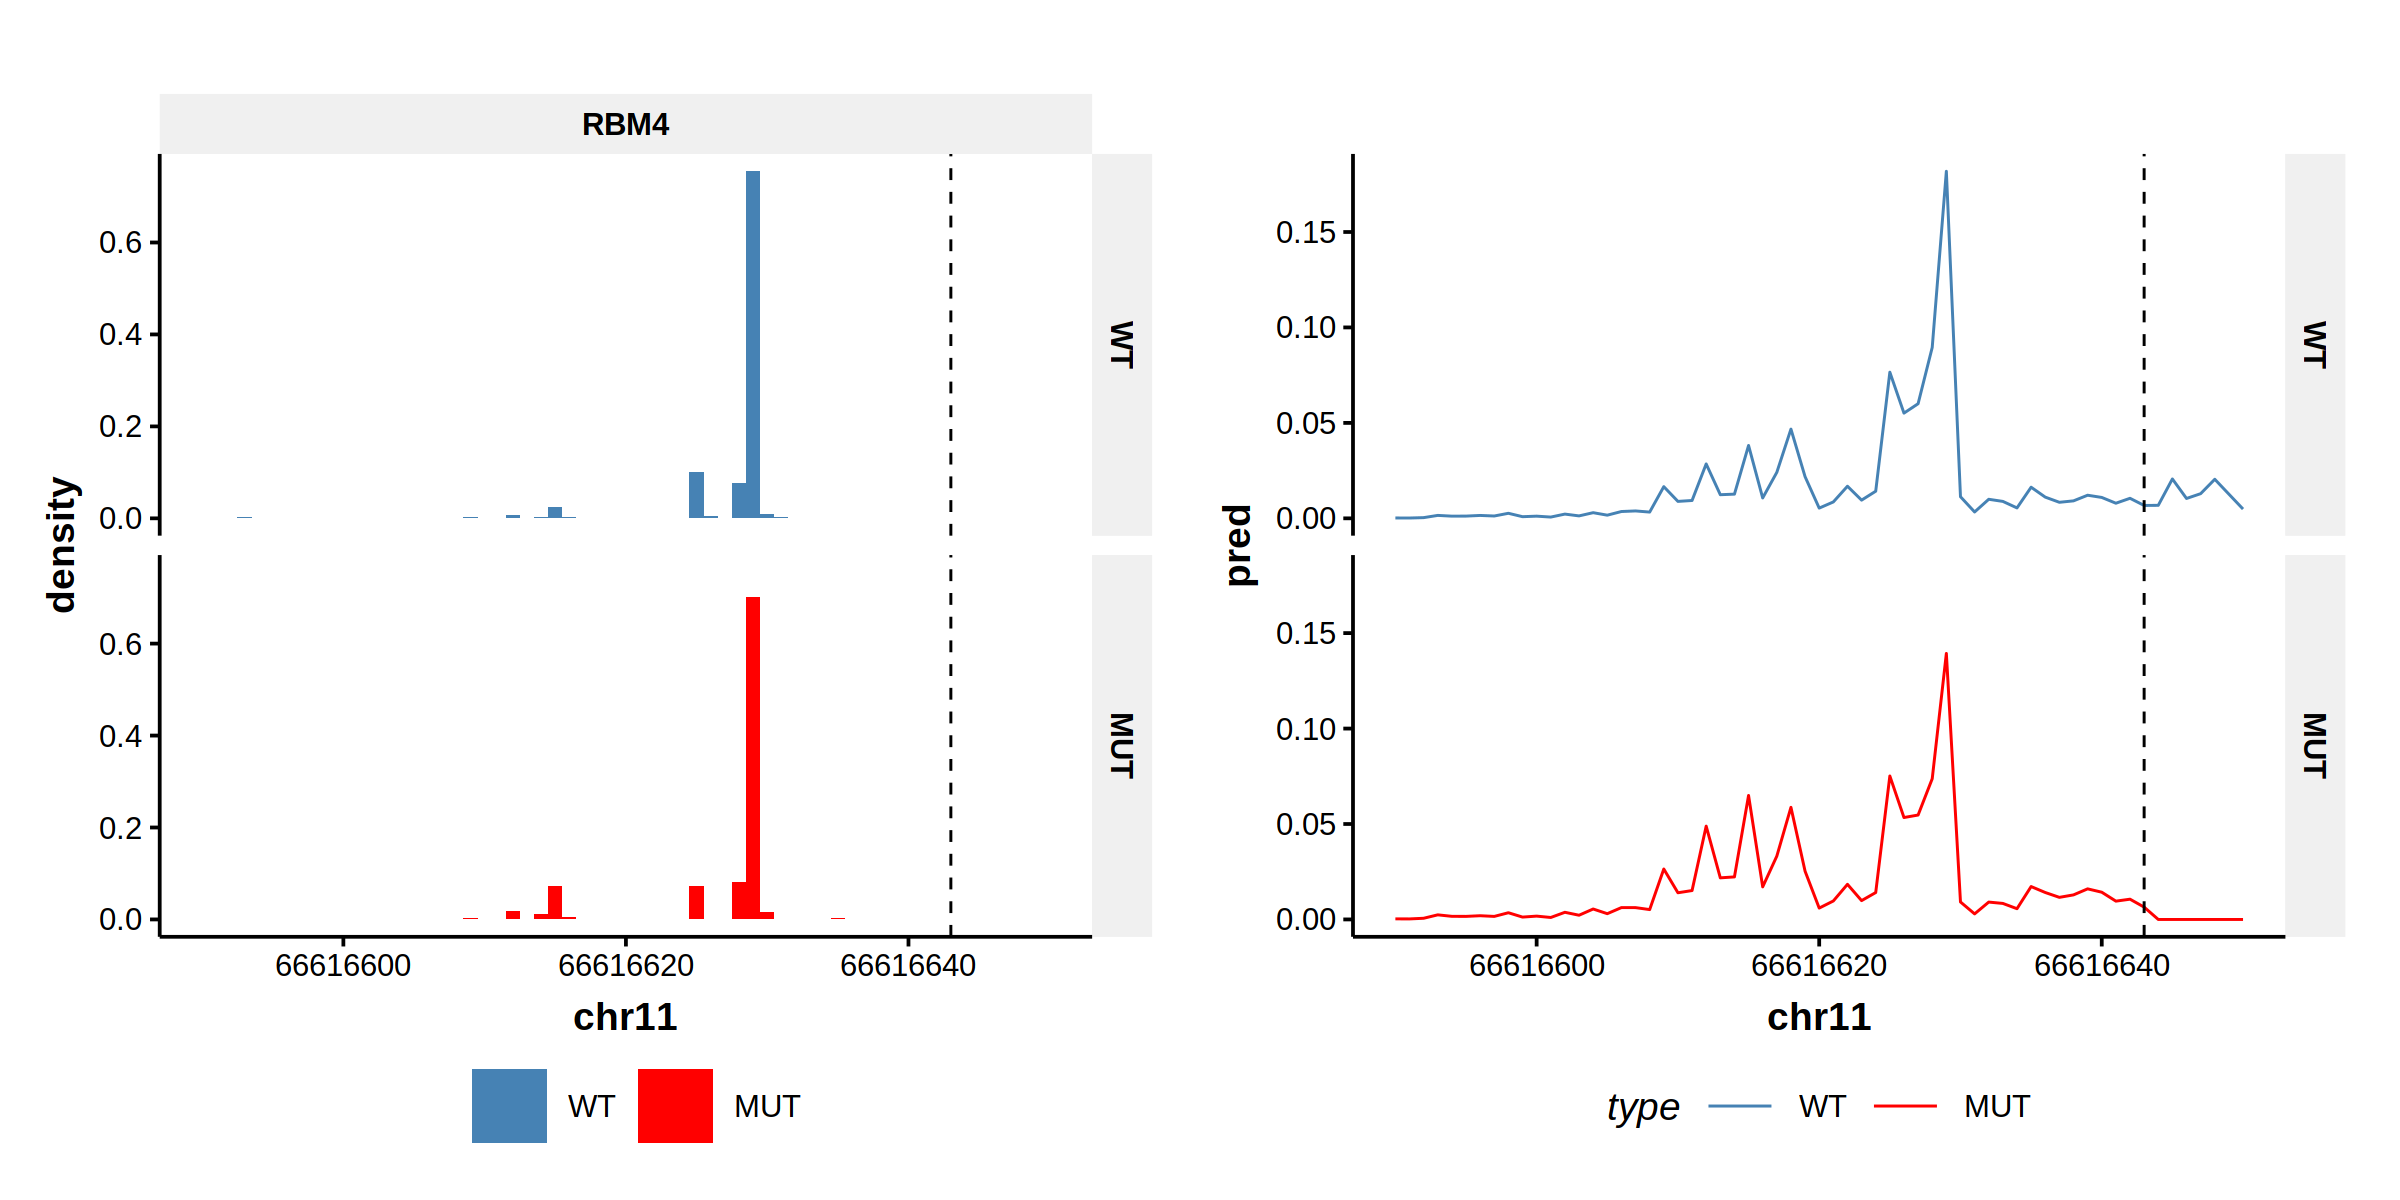

In [ ]:
%%R -w 12 -h 6 --unit in --res 200
#goodish example of shift Long Inr 
p10 = ggplot(data[gene=='RBM4'][((delstart==66616644)& (delend==66616664))|type=='WT']) +
    geom_histogram( aes(x=pos, y=..density.., fill=type),binwidth=1) +
    scale_fill_manual(values=c("steelblue", "red")) +
    labs(fill="")+facet_grid(type~gene)+geom_vline(xintercept=66616629+14, linetype=2)+xlab('chr11')+coord_cartesian(xlim=c(66616590,66616650))+theme_Publication()+xlab('chr11')
p10


plotdata = data.frame(pos = c( seq(66616629-100,66616629+99),  seq(66616629-100,66616629+99)),
                     pred = c(exp(pred_all[[4]])-1,  colMeans(exp(predmuts_all[[4]][ data[gene=='RBM4' & type=='MUT'][,((delstart==66616644)& (delend==66616664)),], ])-1)),
                     #pred = c(pred_all[[7]],  colMeans(predmuts_all[[7]][ data[gene=='NDUFV3' & type=='MUT'][,((delstart>=42893312+12)& dellen>1 & dellen<20),], ])),
                      type = factor(c(rep('WT',200), rep('MUT',200)), levels=c('WT','MUT')))


plotdata2 = data.table::copy(plotdata)
plotdata2 = plotdata2[plotdata2$pos>=66616590 & plotdata2$pos <=66616650,]
plotdata2$pred[plotdata2$type=='WT'] = plotdata2$pred[plotdata2$type=='WT'] / sum(plotdata2$pred[plotdata2$type=='WT'])
plotdata2$pred[plotdata2$type=='MUT'] = plotdata2$pred[plotdata2$type=='MUT'] / sum(plotdata2$pred[plotdata2$type=='MUT'])
p10p = ggplot(plotdata2)+geom_line(aes(x=pos,y=pred, color=type))+  scale_color_manual(values=c("steelblue", "red")) +
    labs(fill="")+facet_grid(type~.)+geom_vline(xintercept=66616629+14, linetype=2)+coord_cartesian(xlim=c(66616590,66616650))+theme_Publication()+xlab('chr11')
p10q = ggplot(plotdata2)+geom_line(aes(x=pos,y=pred, color=type))+  scale_color_manual(values=c("steelblue", "red")) +
    labs(fill="")+geom_vline(xintercept=66616629+14, linetype=2)+coord_cartesian(xlim=c(66616590,66616650))+theme_Publication()+xlab('chr11')

p10+p10p

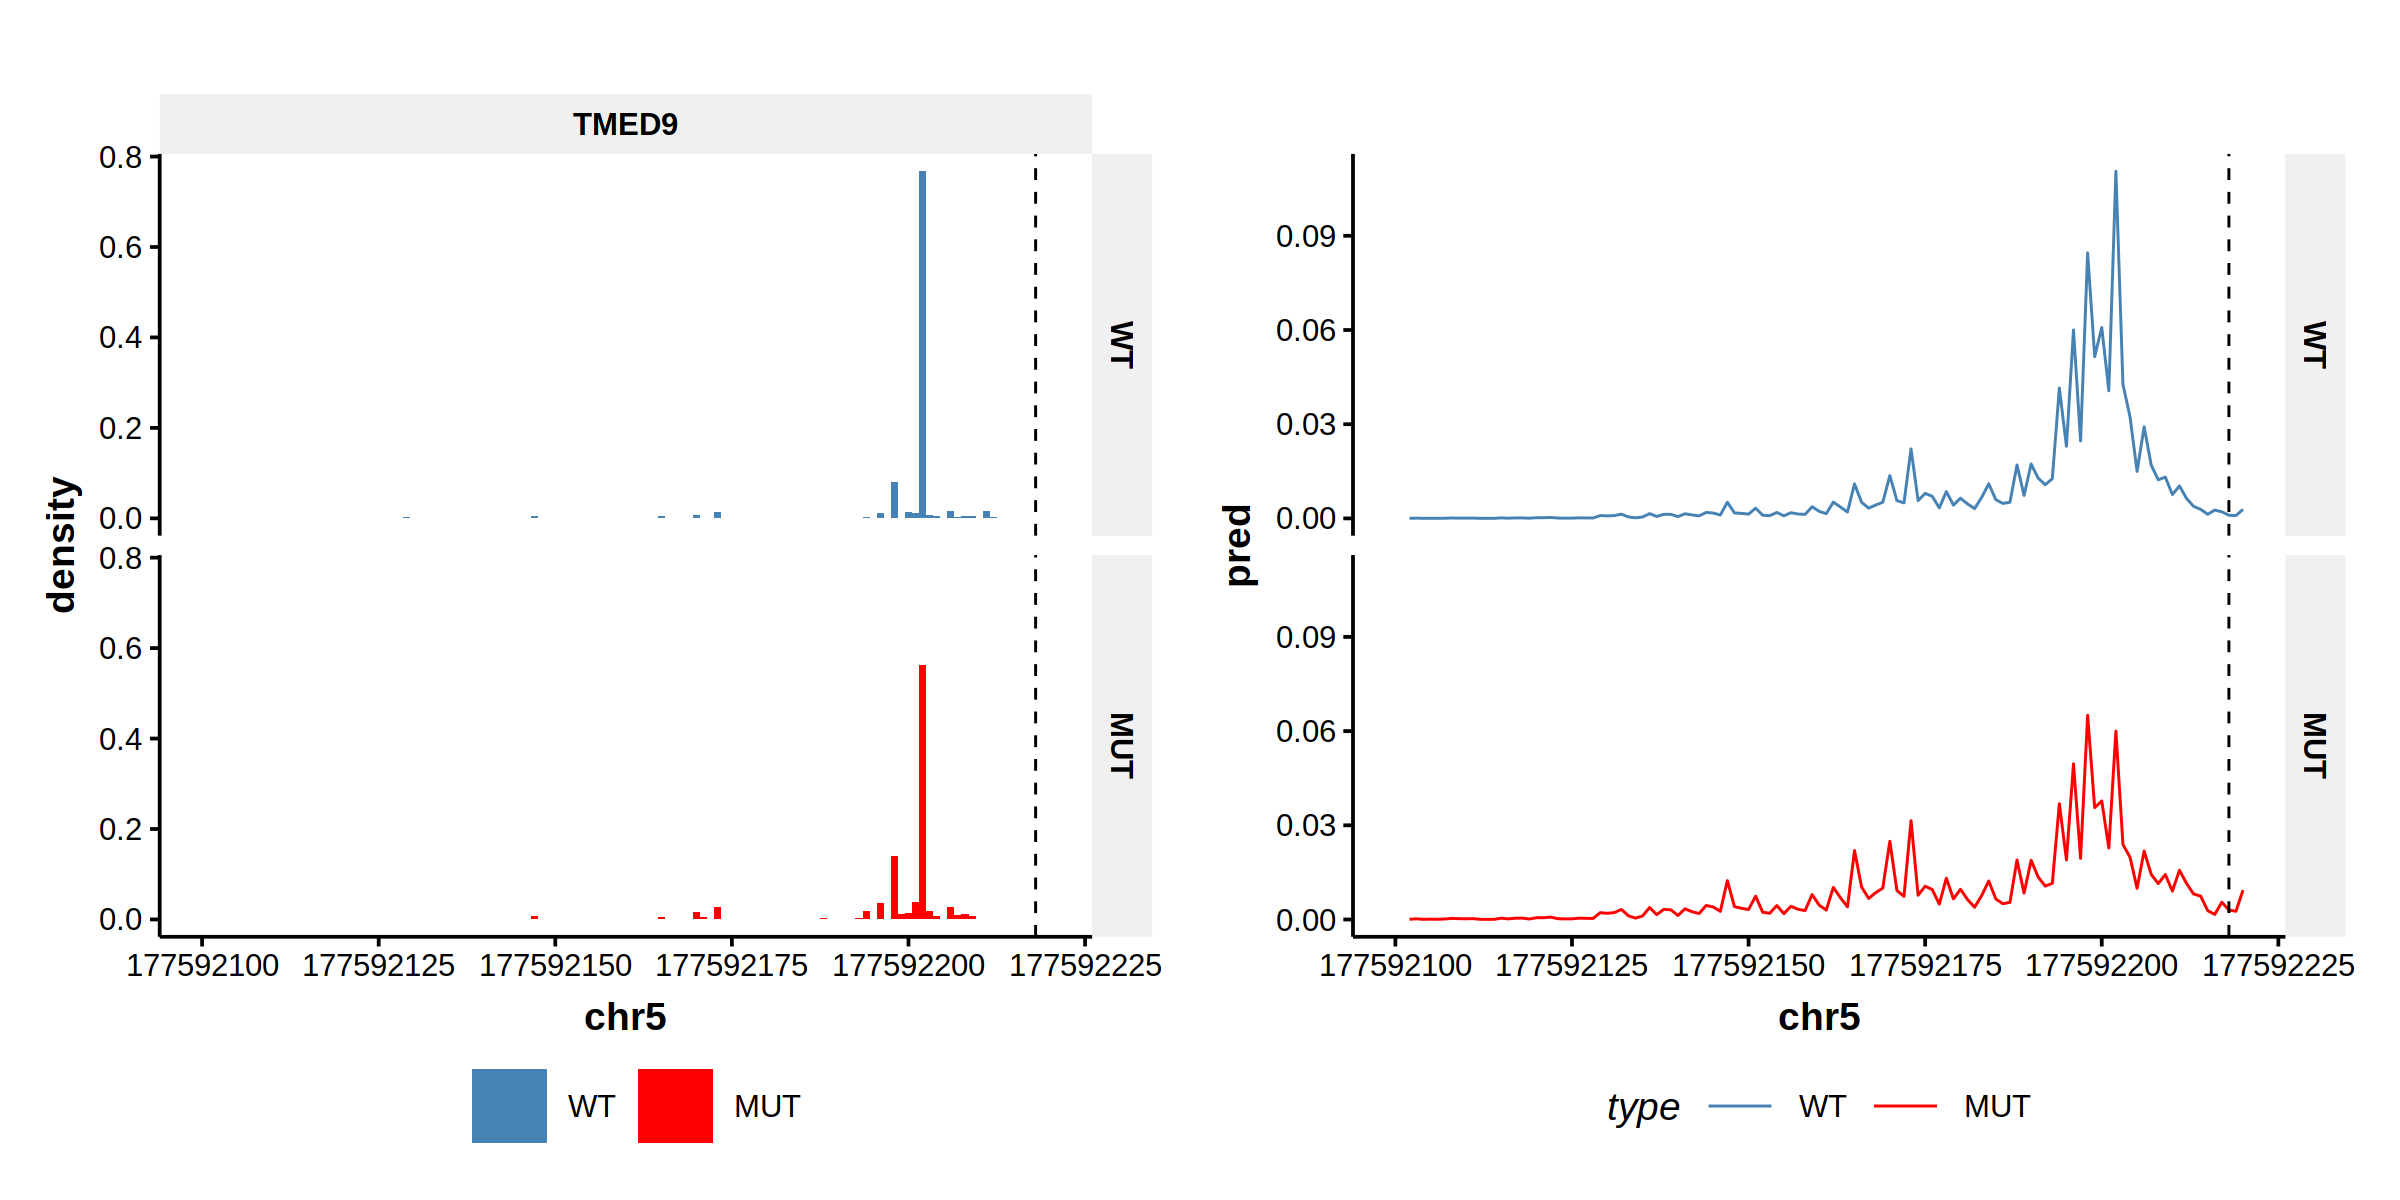

In [ ]:
%%R -w 12 -h 6 --unit in --res 200

#goodish example of shift YY1 
p12 = ggplot(data[gene=='TMED9'][((delstart>=177592202+12)& dellen<20)|type=='WT']) +
    geom_histogram( aes(x=pos, y=..density.., fill=type),binwidth=1) +
    scale_fill_manual(values=c("steelblue", "red")) +
    labs(fill="")+facet_grid(type~gene)+geom_vline(xintercept=177592202+16, linetype=2)+coord_cartesian(xlim=c(177592100,177592220))+theme_Publication()+xlab('chr5')
p12


plotdata = data.frame(pos = c( seq(177592202-100,177592202+99),  seq(177592202-100,177592202+99)),
                     pred = c(exp(pred_all[[6]])-1,  colMeans(exp(predmuts_all[[6]][ data[gene=='TMED9' & type=='MUT'][,((delstart>=177592202+12)& dellen<20),], ])-1)),
                     #pred = c(pred_all[[7]],  colMeans(predmuts_all[[7]][ data[gene=='NDUFV3' & type=='MUT'][,((delstart>=42893312+12)& dellen>1 & dellen<20),], ])),
                      type = factor(c(rep('WT',200), rep('MUT',200)), levels=c('WT','MUT')))


plotdata2 = data.table::copy(plotdata)
plotdata2 = plotdata2[plotdata2$pos>=177592100 & plotdata2$pos <=177592220,]
plotdata2$pred[plotdata2$type=='WT'] = plotdata2$pred[plotdata2$type=='WT'] / sum(plotdata2$pred[plotdata2$type=='WT'])
plotdata2$pred[plotdata2$type=='MUT'] = plotdata2$pred[plotdata2$type=='MUT'] / sum(plotdata2$pred[plotdata2$type=='MUT'])
p12p = ggplot(plotdata2)+geom_line(aes(x=pos,y=pred, color=type))+  scale_color_manual(values=c("steelblue", "red")) +
    labs(fill="")+facet_grid(type~.)+geom_vline(xintercept=177592202+16, linetype=2)+coord_cartesian(xlim=c(177592100,177592220))+theme_Publication()+xlab('chr5')
p12q = ggplot(plotdata2)+geom_line(aes(x=pos,y=pred, color=type))+  scale_color_manual(values=c("steelblue", "red")) +
    labs(fill="")+geom_vline(xintercept=177592202+16, linetype=2)+coord_cartesian(xlim=c(177592100,177592220))+theme_Publication()+xlab('chr5')

p12+p12p

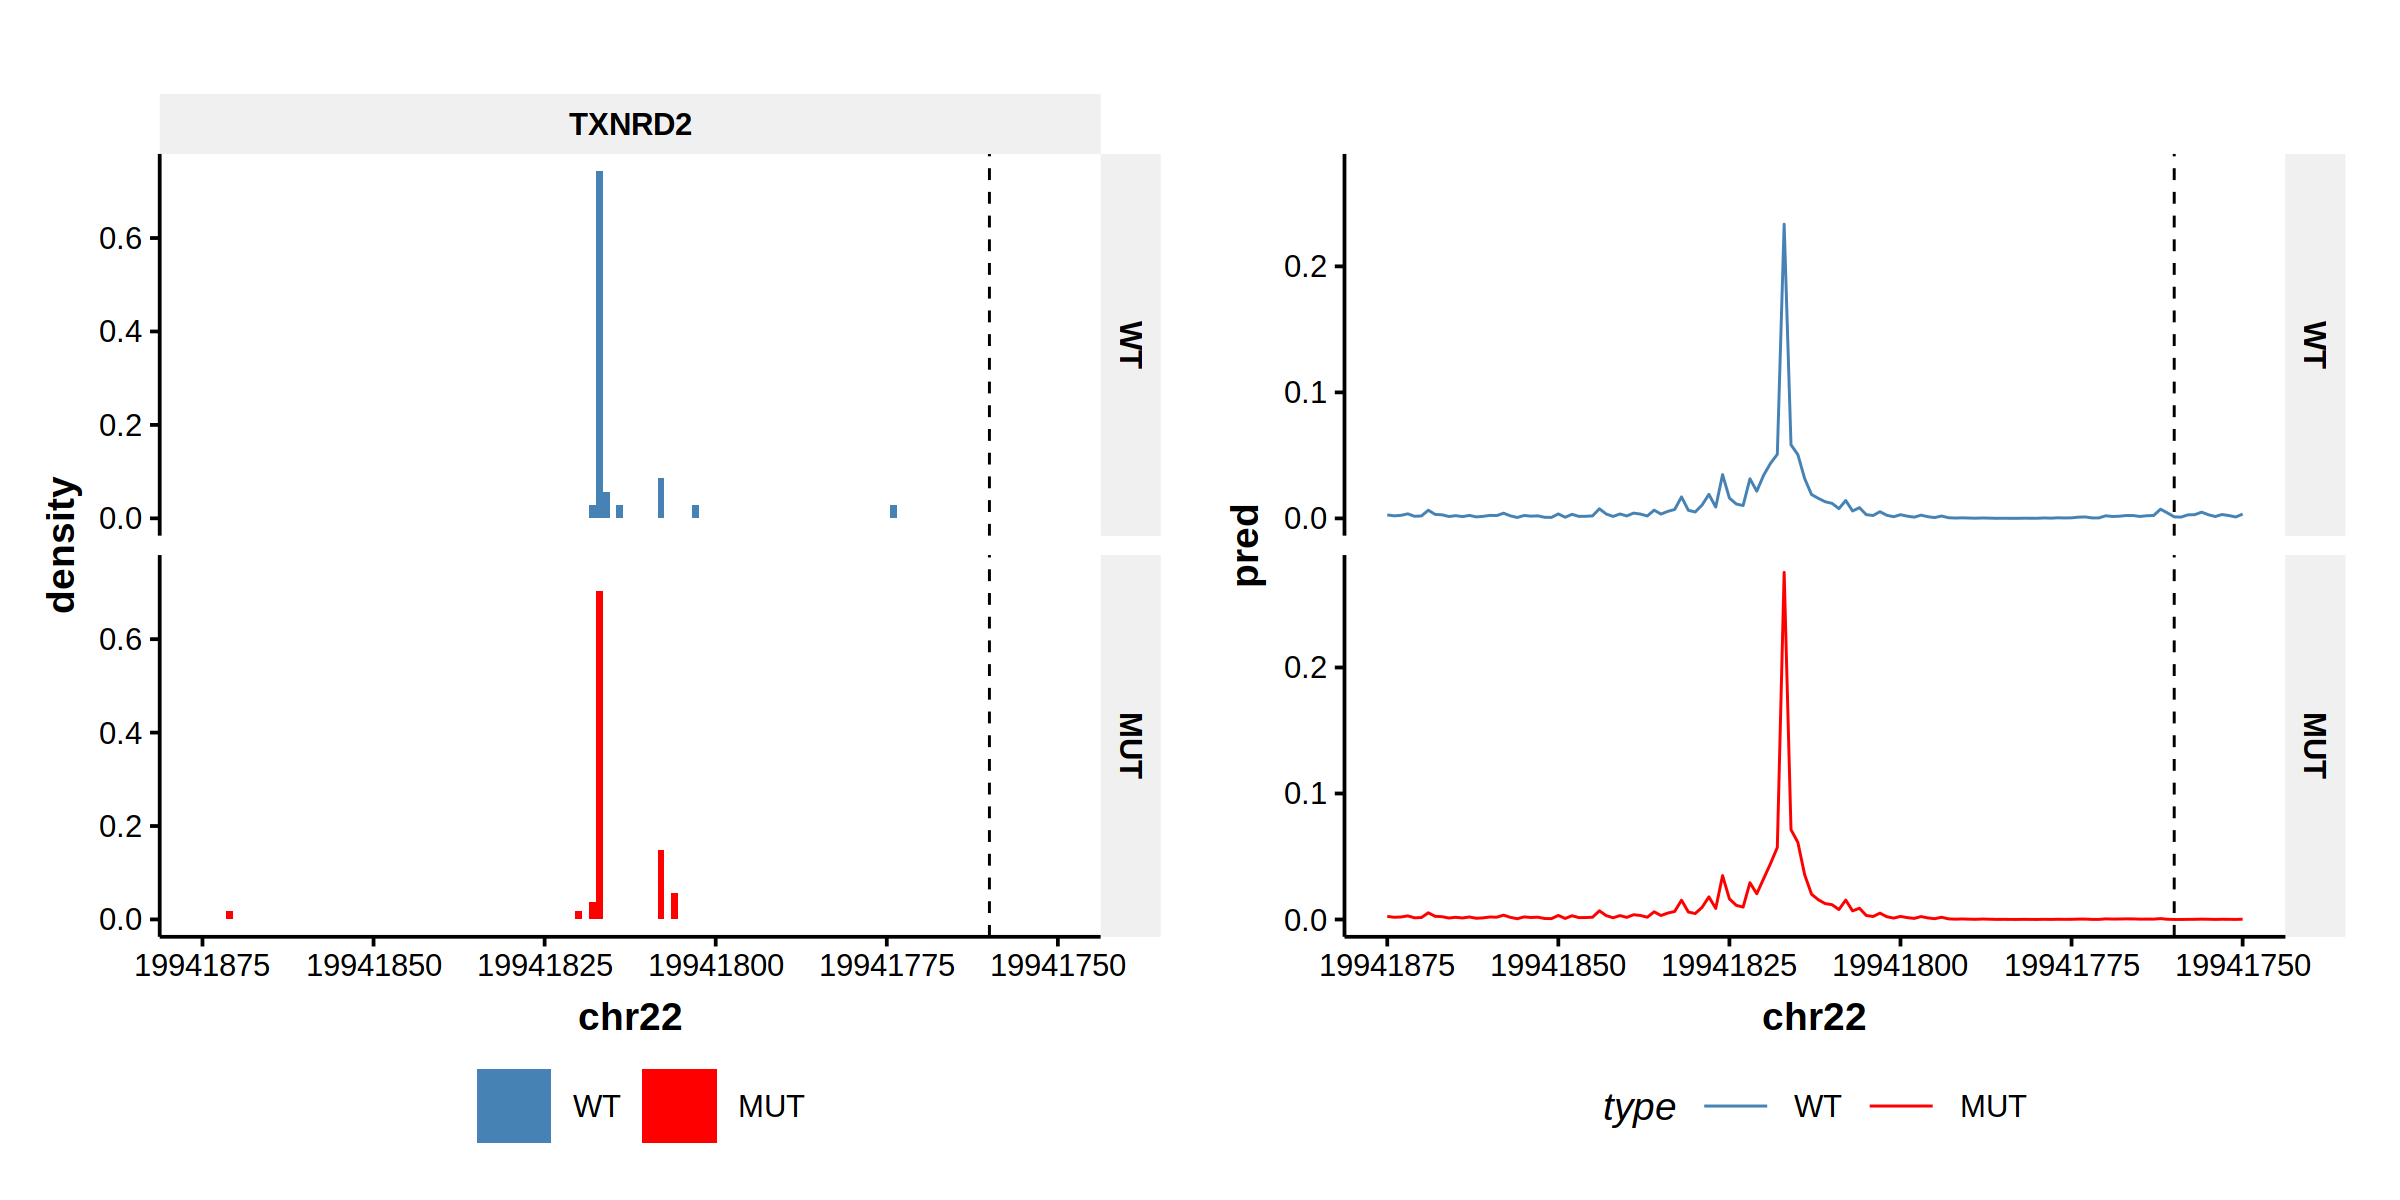

In [ ]:
%%R -w 12 -h 6 --unit in --res 200


#goodish negative example ETS
p13 = ggplot(data[gene=='TXNRD2'][((delend<=19941775-12)& dellen<20)|type=='WT']) +
    geom_histogram( aes(x=pos, y=..density.., fill=type),binwidth=1) +
    scale_fill_manual(values=c("steelblue", "red")) +
    labs(fill="")+facet_grid(type~gene)+geom_vline(xintercept=19941817-57, linetype=2)+coord_cartesian(xlim=c(19941875,19941750))+theme_Publication()+xlab('chr22')

p13



plotdata = data.frame(pos = c( seq(19941817-100,19941817+99),  seq(19941817-100,19941817+99)),
                     pred = c(exp(pred_all[[9]])-1,  colMeans(exp(predmuts_all[[9]][ data[gene=='TXNRD2' & type=='MUT'][,((delend<=19941775-12)& dellen<20),], ])-1)),
                     #pred = c(pred_all[[7]],  colMeans(predmuts_all[[7]][ data[gene=='NDUFV3' & type=='MUT'][,((delstart>=42893312+12)& dellen>1 & dellen<20),], ])),
                      type = factor(c(rep('WT',200), rep('MUT',200)), levels=c('WT','MUT')))


plotdata2 = data.table::copy(plotdata)
plotdata2 = plotdata2[plotdata2$pos>=19941750 & plotdata2$pos <=19941875,]
plotdata2$pred[plotdata2$type=='WT'] = plotdata2$pred[plotdata2$type=='WT'] / sum(plotdata2$pred[plotdata2$type=='WT'])
plotdata2$pred[plotdata2$type=='MUT'] = plotdata2$pred[plotdata2$type=='MUT'] / sum(plotdata2$pred[plotdata2$type=='MUT'])
p13p = ggplot(plotdata2)+geom_line(aes(x=pos,y=pred, color=type))+  scale_color_manual(values=c("steelblue", "red")) +
    labs(fill="")+facet_grid(type~.)+geom_vline(xintercept=19941817-57, linetype=2)+coord_cartesian(xlim=c(19941875,19941750))+theme_Publication()+xlab('chr22')
p13q = ggplot(plotdata2)+geom_line(aes(x=pos,y=pred, color=type))+  scale_color_manual(values=c("steelblue", "red")) +
    labs(fill="")+geom_vline(xintercept=19941817-57, linetype=2)+coord_cartesian(xlim=c(19941875,19941750))+theme_Publication()+xlab('chr22')

p13+p13p

In [ ]:
%%R -w 18 -h 27 --unit in --res 200
#good positives
p6+p8+p9+p10+p6q+p8q+p9q+p10q+p12+p2+p3+p7+p12q+p2q+p3q+p7q+p5+p13+p1+plot_spacer()+p5q+p13q+p1q+plot_spacer()+plot_layout(nrow=6, byrow=T, heights = unit(c(1.5, 1,1.5,1
                                                                                                         ), c('null')))
ggsave('./figures/crisprko_diff.cleaned.pdf', device=cairo_pdf)


Saving 18 x 27 in image
